# Missing Peoples, Bias in Representation, and Exclusion
* Find the ratio of gender in the collection, the ratio of artists by cultures.
* Find the number of works with no artist.
* Look at works with biased keywords for missing people/artists.
* Works from one culture but attributed to another.

In [161]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

from IPython.display import display, Image
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", None)


In [3]:
def search_string_in_dataframe(df, search_string, case_sensitive=False):
    """
    Searches for a string in any field of a Pandas DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to search within.
        search_string (str): The string to search for.
        case_sensitive (bool, optional): Whether the search is case-sensitive. Defaults to False.

    Returns:
         pd.DataFrame: A DataFrame containing rows where the string was found, or an empty DataFrame if not found.
    """
    mask = np.column_stack([df[col].astype(str).str.contains(search_string, case=case_sensitive, na=False).values for col in df])
    return df[mask.any(axis=1)]

In [5]:
df = pd.read_csv('art_objects.csv')

/var/folders/1c/wrs5nr1s5qz6wn412_jlj79c0000gn/T/ipykernel_91640/3176279068.py:1: DtypeWarning: Columns (17,19,25,26,33,35,38,39,40,45,57,59,68,69,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('art_objects.csv')


In [7]:
print(df.info())
df[['people', 'peoplecount']][:5]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245685 entries, 0 to 245684
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    245685 non-null  int64  
 1   copyright                     61840 non-null   object 
 2   contextualtextcount           245685 non-null  int64  
 3   creditline                    245685 non-null  object 
 4   accesslevel                   245685 non-null  int64  
 5   createdate                    245685 non-null  object 
 6   dateoflastpageview            203986 non-null  object 
 7   classificationid              245685 non-null  int64  
 8   division                      238096 non-null  object 
 9   markscount                    245685 non-null  int64  
 10  publicationcount              245685 non-null  int64  
 11  totaluniquepageviews          245685 non-null  int64  
 12  terms                         237452 non-nul

,people,peoplecount
0,"[{'role': 'Artist', 'birthplace': 'New York, NY', 'gender': 'male', 'displaydate': '1871 - 1956', 'prefix': None, 'culture': 'American', 'displayname': 'Lyonel Feininger', 'alphasort': 'Feininger, Lyonel', 'name': 'Lyonel Feininger', 'personid': 20002, 'deathplace': 'New York, NY', 'displayorder': 1}]",1
1,"[{'role': 'Artist', 'birthplace': 'New York, NY', 'gender': 'male', 'displaydate': '1871 - 1956', 'prefix': None, 'culture': 'American', 'displayname': 'Lyonel Feininger', 'alphasort': 'Feininger, Lyonel', 'name': 'Lyonel Feininger', 'personid': 20002, 'deathplace': 'New York, NY', 'displayorder': 1}]",1
2,"[{'role': 'Artist', 'birthplace': 'New York, NY', 'gender': 'male', 'displaydate': '1871 - 1956', 'prefix': None, 'culture': 'American', 'displayname': 'Lyonel Feininger', 'alphasort': 'Feininger, Lyonel', 'name': 'Lyonel Feininger', 'personid': 20002, 'deathplace': 'New York, NY', 'displayorder': 1}]",1
3,"[{'role': 'Artist', 'birthplace': 'New York, NY', 'gender': 'male', 'displaydate': '1871 - 1956', 'prefix': None, 'culture': 'American', 'displayname': 'Lyonel Feininger', 'alphasort': 'Feininger, Lyonel', 'name': 'Lyonel Feininger', 'personid': 20002, 'deathplace': 'New York, NY', 'displayorder': 1}]",1
4,"[{'role': 'Artist', 'birthplace': 'New York, NY', 'gender': 'male', 'displaydate': '1871 - 1956', 'prefix': None, 'culture': 'American', 'displayname': 'Lyonel Feininger', 'alphasort': 'Feininger, Lyonel', 'name': 'Lyonel Feininger', 'personid': 20002, 'deathplace': 'New York, NY', 'displayorder': 1}]",1


### Unpacking 'people' jason objects
The people category is uploaded as a json object, it needs to be unpacked to analyze.

In [12]:
import json
import pandas as pd
import ast  # For safely evaluating strings

df_list = []
data = df.people.values

for json_string in data:
    if pd.isna(json_string):
        df_list.append(None)
    else:
        try:
            # First try direct JSON parsing
            parsed_data = json.loads(json_string)
        except json.JSONDecodeError:
            try:
                # Try fixing common issues
                json_string_fixed = json_string.replace("'", '"')
                parsed_data = json.loads(json_string_fixed)
            except json.JSONDecodeError:
                try:
                    # Last resort - use ast.literal_eval for Python-like syntax
                    parsed_data = ast.literal_eval(json_string)
                except (ValueError, SyntaxError) as e:
                    print(f"Failed to parse: {json_string}")
                    print(f"Error: {str(e)}")
                    parsed_data = None
        
        if parsed_data is not None:
            try:
                normalized_df = pd.json_normalize(parsed_data)
                df_list.append(normalized_df)
            except Exception as e:
                print(f"Normalization failed for: {parsed_data}")
                print(f"Error: {str(e)}")
                df_list.append(None)
        else:
            df_list.append(None)

# Store results
df['people_df'] = df_list

# Show first 2 successful parses
print([x for x in df_list[:2] if x is not None])

[     role    birthplace gender  displaydate prefix   culture  \
0  Artist  New York, NY   male  1871 - 1956   None  American   

        displayname          alphasort              name  personid  \
0  Lyonel Feininger  Feininger, Lyonel  Lyonel Feininger     20002   

     deathplace  displayorder  
0  New York, NY             1  ,      role    birthplace gender  displaydate prefix   culture  \
0  Artist  New York, NY   male  1871 - 1956   None  American   

        displayname          alphasort              name  personid  \
0  Lyonel Feininger  Feininger, Lyonel  Lyonel Feininger     20002   

     deathplace  displayorder  
0  New York, NY             1  ]


## Now we can look at gender, role, and culture of artists. Lets first look at gender.

In [14]:
# For multiple entries per row (if people_df contains multiple rows):
df['genders'] = df['people_df'].apply(lambda x: list(x['gender']) if isinstance(x, pd.DataFrame) and 'gender' in x.columns else [])

In [16]:
print(df['genders'].value_counts())
# Create a mask for lists containing 'female' AND NOT containing 'male'
fem_mask = (
    df['genders'].apply(lambda x: 'female' in x if isinstance(x, list) else False) & 
    ~df['genders'].apply(lambda x: 'male' in x if isinstance(x, list) else False)
)

masc_mask = (
    ~df['genders'].apply(lambda x: 'female' in x if isinstance(x, list) else False) & 
    df['genders'].apply(lambda x: 'male' in x if isinstance(x, list) else False)
)

unknown_mask = (
    ~df['genders'].apply(lambda x: 'female' in x if isinstance(x, list) else False) & 
    ~df['genders'].apply(lambda x: 'male' in x if isinstance(x, list) else False) 
   
)
# Filter the DataFrame
fem_only_df = df[fem_mask]
male_only_df = df[masc_mask]
unkn_df = df[unknown_mask]

# Create the new column
df['male/female'] = [
    'female' if fem else 
    'male' if masc else 
    'unknown' 
    for fem, masc in zip(fem_mask, masc_mask)
]

print(f"There are {len(fem_only_df)} objects attributed to females and {len(male_only_df)} \
objects attributed to males. There are {len(unkn_df)} objects which are attributed to \
people of unknown gender. This give us {round(len(fem_only_df)/len(df)*100, 2)} percent female, and \
{round(len(male_only_df)/len(df)*100, 2)} male, {round(len(unkn_df)/len(df)*100, 2)} percent   attributed items.")

genders
[male]                                                                                                                                           125241
[unknown]                                                                                                                                         52864
[]                                                                                                                                                31193
[male, male]                                                                                                                                      11005
[male, unknown]                                                                                                                                    7694
[female]                                                                                                                                           4924
[unknown, unknown]                                                              

## After some analysis, we see that of the approximately 250K items, 2.2% are female-attributed, 61.3% are male-attributed,and the remaining 36.2% are attributed to an unknown gender.
Likely, there are far more objects made by women than are attributed to them in the records. One area where this could be amended is within categories where objects would have been traditionally made by women: pottery, textiles, etc. 

### Objects where a creation date is not known are disproportionately attributed to men over being unknown or female.

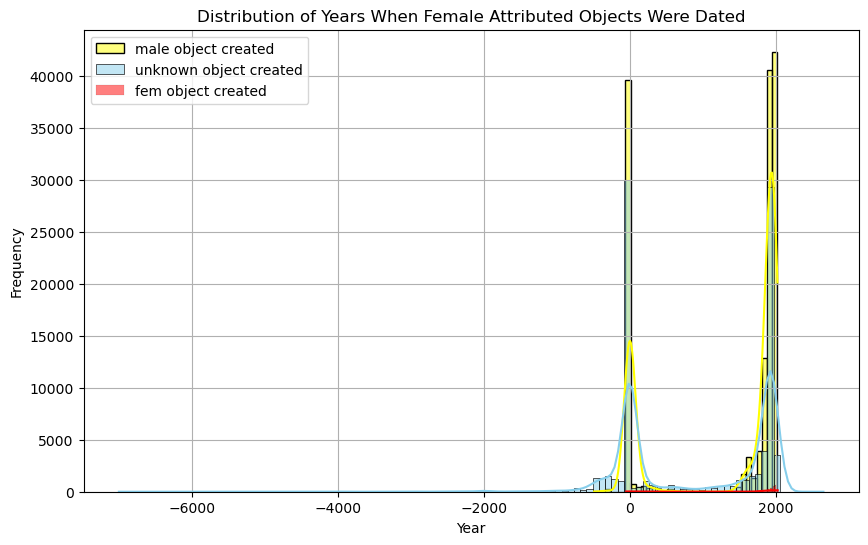

In [340]:
plt.figure(figsize=(10, 6))

sns.histplot(data=male_only_df, x='dateend', kde=True, color = 'yellow', label = "male object created")
sns.histplot(data=unkn_df, x='dateend', kde=True, color="skyblue", label = "unknown object created")
sns.histplot(data=fem_df, x='dateend', kde=True, color = 'red', label = "fem object created")
plt.title('Distribution of Years When Female Attributed Objects Were Dated')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

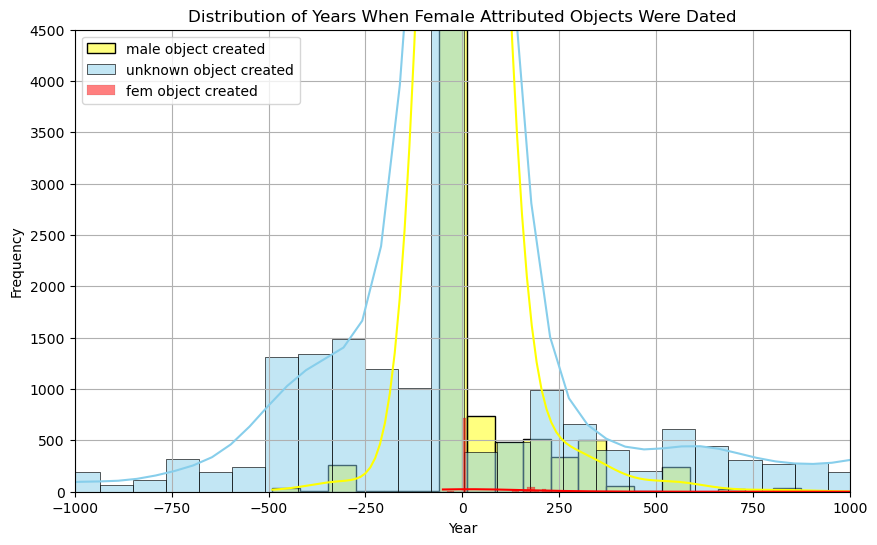

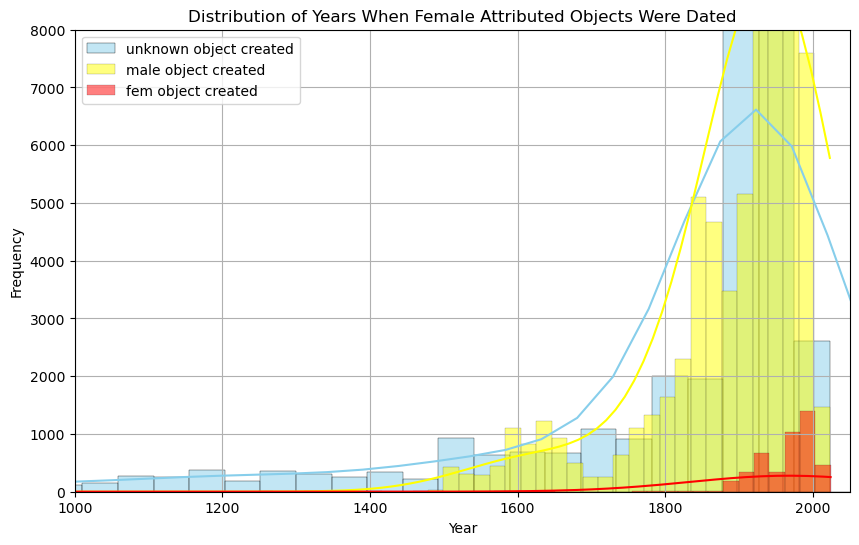

In [50]:

plt.figure(figsize=(10, 6))


sns.histplot(data=male_only_df, x='dateend', kde=True, color = 'yellow', label = "male object created")
sns.histplot(data=unkn_df, x='dateend', kde=True, color="skyblue", label = "unknown object created")
sns.histplot(data=fem_only_df, x='dateend', kde=True, color = 'red', label = "fem object created")
plt.title('Distribution of Years When Female Attributed Objects Were Dated')
plt.xlim(-1000, 1000)
plt.ylim(0, 4500)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))



sns.histplot(data=unkn_df, x='dateend', kde=True, color="skyblue", label = "unknown object created", bins = 200)
sns.histplot(data=male_only_df, x='dateend', kde=True, color = 'yellow', label = "male object created", bins = 120)
sns.histplot(data=fem_only_df, x='dateend', kde=True, color = 'red', label = "fem object created", bins = 100)
plt.title('Distribution of Years When Female Attributed Objects Were Dated')
plt.xlim(1000, 2050)
plt.ylim(0, 8000)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### Most of the pre 1500 objects are of unknown gender aside from a cluster of male attributed items between years 0 and 600.
### There is an exponential increase in male attributed objects beginning around 1500 and peaking at 2000. 
### The only female attributed items exist in a cluster beginning around 1900 with a linear increase also peaking at the year 2000.

In [20]:
recent_women = (fem_only_df['dateend']>= 2000).sum()
recent_men = (male_only_df['dateend']>= 2000).sum()
recent_unknown = (unkn_df['dateend']>= 2000).sum()
total = recent_women + recent_men + recent_unknown
print(f"From objects made in the last 25 years {round(recent_women/total *100,2)} percent were attributed to women while \
{round(recent_men/total *100,2)} percent were attributed to men and {round(recent_unknown/total *100,2)} percent were unknown.")

From objects made in the last 25 years 19.26 percent were attributed to women while 58.53 percent were attributed to men and 22.2 percent were unknown.


In [382]:
recent_women = ((fem_only_df['dateend']<= 2000) & (fem_only_df['dateend']>= 1975)).sum()
recent_men = ((male_only_df['dateend']<= 2000) & (male_only_df['dateend']>= 1975)).sum()
recent_unknown = ((unkn_df['dateend']<= 2000) & (unkn_df['dateend']>= 1975)).sum()
total = recent_women + recent_men + recent_unknown
print(f"From objects made between 1975-2000 {round(recent_women/total *100,2)} percent were attributed to women while \
{round(recent_men/total *100,2)} percent were attributed to men and {round(recent_unknown/total *100,2)} percent were unknown.")

From objects made between 1950-2000 10.2 percent were attributed to women while 76.38 percent were attributed to men and 13.42 percent were unknown.


In [384]:
recent_women = ((fem_only_df['dateend']<= 1975) & (fem_only_df['dateend']>= 1950)).sum()
recent_men = ((male_only_df['dateend']<= 1975) & (male_only_df['dateend']>= 1950)).sum()
recent_unknown = ((unkn_df['dateend']<= 1975) & (unkn_df['dateend']>= 1950)).sum()
total = recent_women + recent_men + recent_unknown
print(f"From objects made between 1975-2000 {round(recent_women/total *100,2)} percent were attributed to women while \
{round(recent_men/total *100,2)} percent were attributed to men and {round(recent_unknown/total *100,2)} percent were unknown.")

From objects made between 1975-2000 2.08 percent were attributed to women while 76.58 percent were attributed to men and 21.34 percent were unknown.


## Here we plot the HAM objects by year by percent gender.

### We see a Dramatic Increase in proportion of female-attributed items
Beginning in the year 2010 the percentage of objects collected attributed to men have begun to decrease while the percentage attributed to women had increased. This shift is dramatic. Near 2018 the percentage of female attributed objects overtook the male reaching a ratio as high as 100:1 in the last few years.

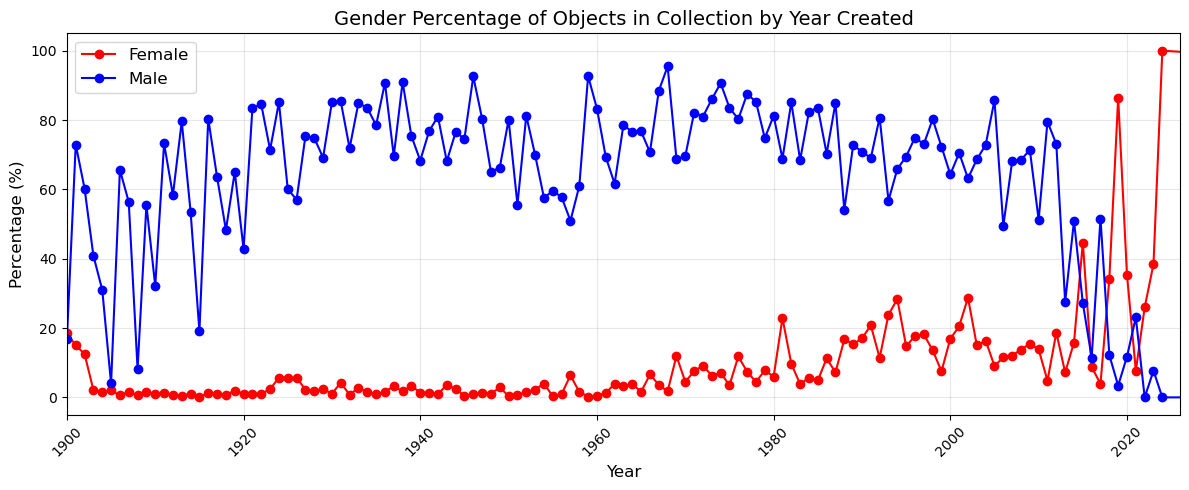

In [171]:
gender_by_year = (
    df.groupby(['dateend', 'male/female'])
    .size()
    .unstack(fill_value=0)
)
gender_by_year = gender_by_year.div(gender_by_year.sum(axis=1), axis=0) * 100

# 3. Plot the results
plt.figure(figsize=(12, 5))

# Plot female percentage
plt.plot(gender_by_year.index, gender_by_year['female'], 
         label='Female', color='red', marker='o')

# Plot male percentage
plt.plot(gender_by_year.index, gender_by_year['male'], 
         label='Male', color='blue', marker='o')

# Formatting
plt.title('Gender Percentage of Objects in Collection by Year Created', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Rotate x-axis labels if many years
if len(gender_by_year) > 10:
    plt.xticks(rotation=45)
    plt.xlim(1900, 2026)

plt.tight_layout()
plt.show()

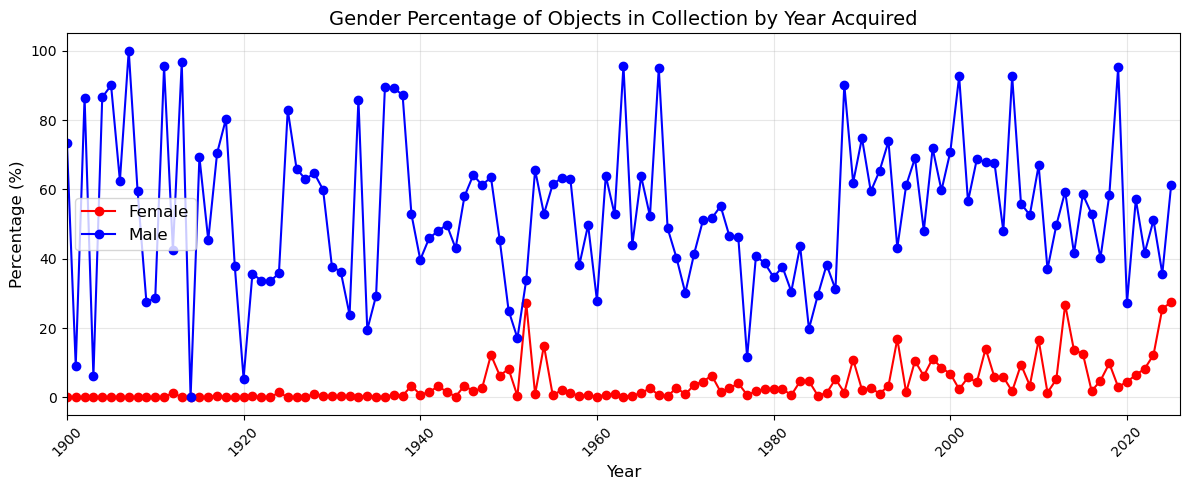

In [175]:
gender_by_year = (
    df.groupby(['accessionyear', 'male/female'])
    .size()
    .unstack(fill_value=0)
)
gender_by_year = gender_by_year.div(gender_by_year.sum(axis=1), axis=0) * 100

# 3. Plot the results
plt.figure(figsize=(12, 5))

# Plot female percentage
plt.plot(gender_by_year.index, gender_by_year['female'], 
         label='Female', color='red', marker='o')

# Plot male percentage
plt.plot(gender_by_year.index, gender_by_year['male'], 
         label='Male', color='blue', marker='o')

# Formatting
plt.title('Gender Percentage of Objects in Collection by Year Acquired', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Rotate x-axis labels if many years
if len(gender_by_year) > 10:
    plt.xticks(rotation=45)
    plt.xlim(1900, 2026)

plt.tight_layout()
plt.show()

## Let's do the same alaysis but with objects that are eventually exhibited. 
### We see the same shift here but much more gradual.

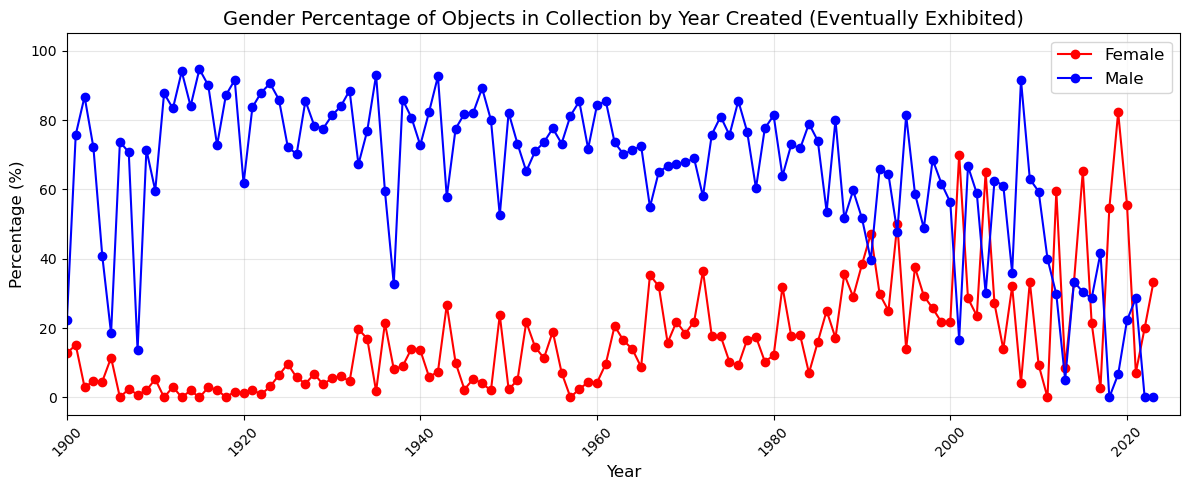

In [177]:
exhibited_df = df[df['exhibitioncount']>0]
gender_by_year = (
    exhibited_df.groupby(['dateend', 'male/female'])
    .size()
    .unstack(fill_value=0)
)
gender_by_year = gender_by_year.div(gender_by_year.sum(axis=1), axis=0) * 100

# 3. Plot the results
plt.figure(figsize=(12, 5))

# Plot female percentage
plt.plot(gender_by_year.index, gender_by_year['female'], 
         label='Female', color='red', marker='o')

# Plot male percentage
plt.plot(gender_by_year.index, gender_by_year['male'], 
         label='Male', color='blue', marker='o')

# Formatting
plt.title('Gender Percentage of Objects in Collection by Year Created (Eventually Exhibited)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Rotate x-axis labels if many years
if len(gender_by_year) > 10:
    plt.xticks(rotation=45)
    plt.xlim(1900, 2026)

plt.tight_layout()
plt.show()


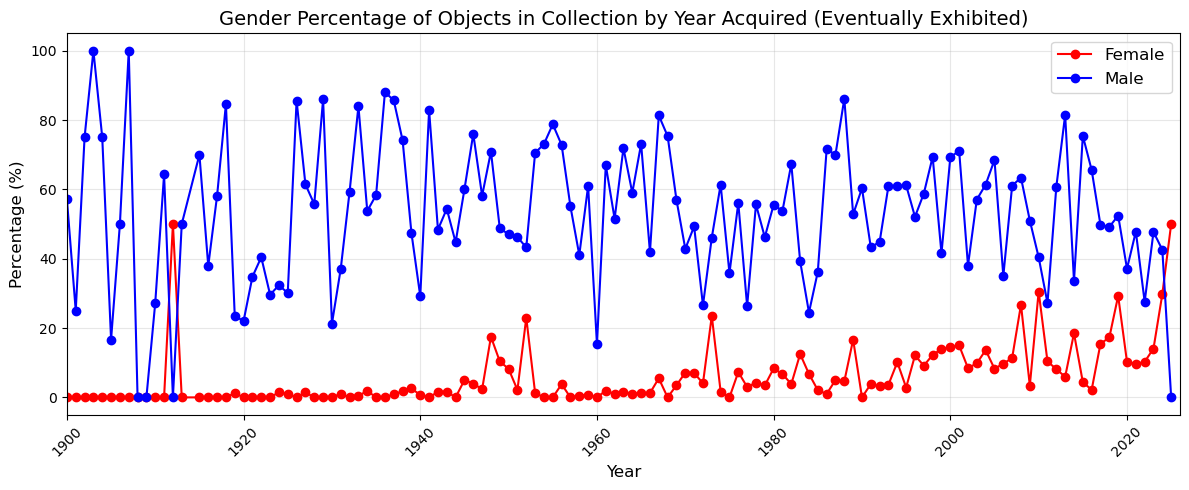

In [179]:
exhibited_df = df[df['exhibitioncount']>0]
gender_by_year = (
    exhibited_df.groupby(['accessionyear', 'male/female'])
    .size()
    .unstack(fill_value=0)
)
gender_by_year = gender_by_year.div(gender_by_year.sum(axis=1), axis=0) * 100

# 3. Plot the results
plt.figure(figsize=(12, 5))

# Plot female percentage
plt.plot(gender_by_year.index, gender_by_year['female'], 
         label='Female', color='red', marker='o')

# Plot male percentage
plt.plot(gender_by_year.index, gender_by_year['male'], 
         label='Male', color='blue', marker='o')

# Formatting
plt.title('Gender Percentage of Objects in Collection by Year Acquired (Eventually Exhibited)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Rotate x-axis labels if many years
if len(gender_by_year) > 10:
    plt.xticks(rotation=45)
    plt.xlim(1900, 2026)

plt.tight_layout()
plt.show()

## We can also look at trends in the gender of artists exhibited each year

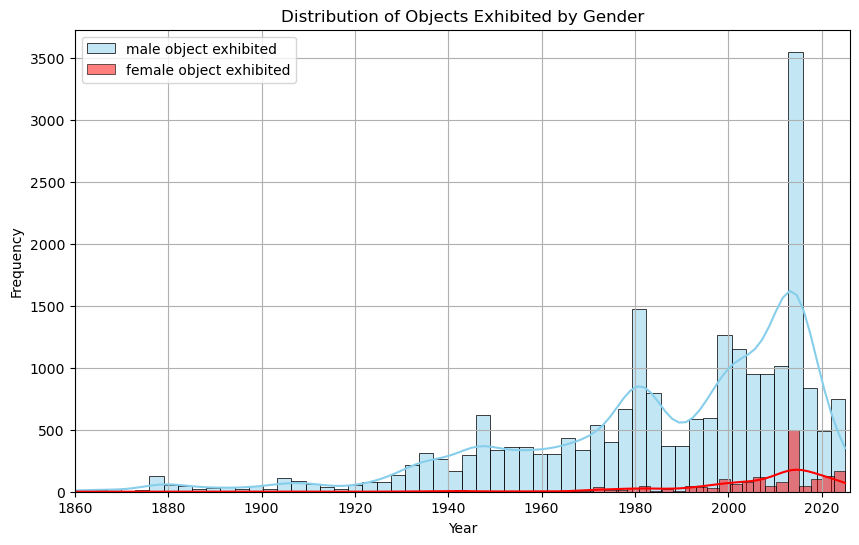

In [163]:

df_list = []
data = exhibited_df.exhibitions.values

for json_string in data:
    if pd.isna(json_string):
        df_list.append(None)
    else:
        try:
            # First try direct JSON parsing
            parsed_data = json.loads(json_string)
        except json.JSONDecodeError:
            try:
                # Try fixing common issues
                json_string_fixed = json_string.replace("'", '"')
                parsed_data = json.loads(json_string_fixed)
            except json.JSONDecodeError:
                try:
                    # Last resort - use ast.literal_eval for Python-like syntax
                    parsed_data = ast.literal_eval(json_string)
                except (ValueError, SyntaxError) as e:
                    print(f"Failed to parse: {json_string}")
                    print(f"Error: {str(e)}")
                    parsed_data = None
        
        if parsed_data is not None:
            try:
                normalized_df = pd.json_normalize(parsed_data)
                df_list.append(normalized_df)
            except Exception as e:
                print(f"Normalization failed for: {parsed_data}")
                print(f"Error: {str(e)}")
                df_list.append(None)
        else:
            df_list.append(None)

# Store results
exhibited_df['exhibitions_df'] = df_list

exhibited_df['exhibitions_df'][:3]
exhibited_df.loc[:,'exhibitions_date'] = exhibited_df.exhibitions_df.apply(lambda x: list(x['begindate']) if isinstance(x, pd.DataFrame) and 'begindate' in x.columns else [])

m_exhibited = exhibited_df[exhibited_df['male/female'] == 'male']
f_exhibited = exhibited_df[exhibited_df['male/female'] == 'female']
m_list = []
f_list = []
from itertools import chain

m_list.append([i[:] for i in m_exhibited['exhibitions_date'].values])
m_list_flattened = list(chain.from_iterable(chain.from_iterable(m_list)))
m_list_flattened = pd.to_datetime(m_list_flattened, format='ISO8601').year.tolist()
f_list.append(i for i in f_exhibited['exhibitions_date'].values[:])
f_list_flattened = list(chain.from_iterable(chain.from_iterable(f_list)))
f_list_flattened = pd.to_datetime(f_list_flattened, format='ISO8601').year.tolist()


plt.figure(figsize=(10, 6))


sns.histplot(m_list_flattened , kde=True, color = 'skyblue', label = "male object exhibited")
sns.histplot(f_list_flattened , kde=True, color="red", label = "female object exhibited")

plt.title('Distribution of Objects Exhibited by Gender')
plt.xlim(1860, 2026)
#plt.ylim(0, 4500)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


## Why was there a sudden drop in the percent of number of artworks made by men in the 2020s?
Many 'people' fields contain an unknown gender

In [199]:
df[df['dateend']>= 2020][['dateend', 'people_df', 'male/female']]

,dateend,people_df,male/female
87459,2650,None,unknown
169670,2020,"role birthplace gender displaydate prefix culture \ 0 Artist Ilé-If?`, Nigeria female born 1985 None American displayname alphasort name personid \ 0 Toyin Ojih Odutola Ojih Odutola, Toyin Toyin Ojih Odutola 68282 deathplace displayorder 0 None 1",female
169671,2020,"role birthplace gender displaydate prefix culture \ 0 Artist Ilé-If?`, Nigeria female born 1985 None American displayname alphasort name personid \ 0 Toyin Ojih Odutola Ojih Odutola, Toyin Toyin Ojih Odutola 68282 deathplace displayorder 0 None 1",female
169672,2020,"role birthplace gender displaydate prefix culture \ 0 Artist Ilé-If?`, Nigeria female born 1985 None American displayname alphasort name personid \ 0 Toyin Ojih Odutola Ojih Odutola, Toyin Toyin Ojih Odutola 68282 deathplace displayorder 0 None 1",female
169824,2020,"role birthplace gender displaydate prefix culture displayname \ 0 Artist San Francisco, CA male born 1969 None American Will Wilson alphasort name personid deathplace displayorder 0 Wilson, Will Will Wilson 68321 None 1",male
170573,2020,"role birthplace gender displaydate prefix culture displayname \ 0 Artist None unknown born 1971 None None Hong Chun Zhang 張春紅 alphasort name personid deathplace displayorder 0 Zhang, Hong Chun Hong Chun Zhang 張春紅 68583 None 1",unknown
170574,2020,"role birthplace gender displaydate prefix culture displayname \ 0 Artist None unknown born 1971 None None Hong Chun Zhang 張春紅 alphasort name personid deathplace displayorder 0 Zhang, Hong Chun Hong Chun Zhang 張春紅 68583 None 1",unknown
170575,2020,"role birthplace gender displaydate prefix culture displayname \ 0 Artist None unknown born 1971 None None Hong Chun Zhang 張春紅 alphasort name personid deathplace displayorder 0 Zhang, Hong Chun Hong Chun Zhang 張春紅 68583 None 1",unknown
170576,2020,"role birthplace gender displaydate prefix culture displayname \ 0 Artist None unknown born 1971 None None Hong Chun Zhang 張春紅 alphasort name personid deathplace displayorder 0 Zhang, Hong Chun Hong Chun Zhang 張春紅 68583 None 1",unknown
170736,2021,"role birthplace gender displaydate prefix culture \ 0 Artist None male born 1969 None American displayname alphasort \ 0 Michael Cherney (also known as Qiu Mai 秋麥) Cherney, Michael name personid deathplace \ 0 Michael Cherney (also known as Qiu Mai 秋麥) 55097 None displayorder 0 1",male


## Looking at how people are represented in the'person' field. Who is left out?

In [162]:
print(df['classification'].value_counts())
df = df[~df['classification'].isin(['Straus Materials', "Artists' Tools"])]

classification
Photographs                   82939
Prints                        69151
Drawings                      31055
Coins                         18055
Archival Material              8498
Paintings                      5932
Vessels                        5052
Sculpture                      4734
Fragments                      3864
Manuscripts                    1910
Textile Arts                   1839
Straus Materials               1116
Artists' Tools                 1077
Multiples                       907
Ritual Implements               901
Tools and Equipment             787
Seals                           724
Jewelry                         723
Medals and Medallions           574
Calligraphy                     534
Architectural Elements          526
Books                           489
Lighting Devices                472
Albums                          408
Plaques                         375
Furniture                       247
Rubbings                        242
Artists' Mate

In [170]:

no_df = df[df['peoplecount'] ==0]
print(f"There are {no_df.shape[0]} records with no people attributed to them.")
for index, row in no_df[:30].iterrows():
    if not pd.isna(row['primaryimageurl']):
        image_path = row['primaryimageurl']
        display(Image(url = image_path, width = 300))
        print(row['title'])
        print(row['dateend'])
        print(row['culture'])


There are 30263 records with no people attributed to them.


Oil flask (aryballos) with the heads of a Black African and an Egyptian
6
Greek


Lamp
200
Roman


Probe
300
Roman


Pin with Decorative Comb Finial
500
Roman


Spoon
1300
Unidentified culture


Coin of Perge
0
Roman Provincial


Coin of Perge
0
Roman Provincial


Coin of Perge
0
Roman Provincial


Coin of Perge
0
Roman Provincial


Coin of Perge
0
Roman Provincial


Reproduction of a Classical Head possibly Zeus or Aesclepius
0
nan


Brick Stamp of P. Servilius Fortunatus
150
Roman


Coin of Perge
0
Roman Provincial


Coin of Perge
0
Roman Provincial


Coin of Perge
0
Roman Provincial


Coin of Perge
0
Roman Provincial


Coin of Perge
0
Roman Provincial


Spatula
400
Roman


Coin of Perge
0
Roman Provincial


Coin of Perge
0
Roman Provincial


Cylindrical container depicting the Battle of Greeks and Amazons in a Classical style
1900
nan


Coin of Aspendos
0
Roman Provincial


Coin of Perge
0
Roman Provincial


Coin of Perge
0
Roman Provincial


Coin of Perge
0
Roman Provincial


Coin of Perge
0
Roman Provincial


Knucklebone
-1
Graeco-Roman


Coin of Perge?
0
Roman Provincial


Coin
0
nan


Folio from a Qur'an: Sura 50: 24-39 (recto), Sura 50: 39-45 and Sura 51: 1-12 (verso)
1700
Persian


## Here we notice that most of the objects are from antiquity, which is why there is not an artist attributed.

In [174]:
recent_no_df = no_df[no_df['dateend'] > 1900]
recent = recent_no_df.shape[0]
print(f"There are {recent} records after 1900 with no people attributed to them.")

for index, row in recent_no_df[50:100].iterrows():
    if not pd.isna(row['primaryimageurl']):
        image_path = row['primaryimageurl']
        display(Image(url = image_path, width = 300))
        print(row['title'])
        print(row['dateend'])
        print(row['culture'])
        print(row['classification'])

There are 1047 records after 1900 with no people attributed to them.


X-radiograph(s) of "Portrait of Unknown Judge"
1960
nan
Photographs


X-radiograph(s) of "Dutch Palette"
1966
nan
Photographs


X-radiograph(s) of "Portrait of a Dutch Lady"
1967
nan
Photographs


X-radiograph(s) of "Portrait of Timothy Thompson"
1968
nan
Photographs


X-radiograph(s) of "Bronzes Experiment"
1971
nan
Photographs


X-radiograph(s) of "Russian Icon"
1971
nan
Photographs


X-radiograph(s) of "Panel"
1972
nan
Photographs


X-radiograph(s) of "Figures in Landscape"
1972
nan
Photographs


X-radiograph(s) of "Altarpiece"
1979
nan
Photographs


X-radiograph(s) of "Crucifix"
1981
nan
Photographs


X-radiograph(s) of "Portrait of Sir George Downing"
1981
nan
Photographs


X-radiograph(s) of "Nativity"
1984
nan
Photographs


X-radiograph(s) of "Chinese Scroll"
1985
nan
Photographs


X-radiograph(s) of "Profile Portrait Head"
1986
nan
Photographs


X-radiograph(s) of "Franklin House Wall Panel"
1986
nan
Photographs


X-radiograph(s) of "St. Barbara"
1988
nan
Photographs


X-radiograph(s) of "Vice Admiral Samuel Hood Linzee (1773-1820)"
1991
nan
Photographs


X-radiograph(s) of "Portrait of C.T. Wells"
1991
nan
Photographs


X-radiograph(s) of "Madonna and Child and Sts. Catherine and Barbara"
1995
nan
Photographs


X-radiograph(s)
1995
nan
Photographs


X-radiograph(s) of "Annunciation"
2004
nan
Photographs


X-radiograph(s) of "Orpheus and Eurydice"
2005
nan
Photographs


X-radiograph(s) of "Portrait of Abraham Lincoln"
2005
nan
Photographs


X-radiograph(s) of "Annunciation to the Madonna of her Approaching Death"
2007
nan
Photographs


X-radiograph(s) of "The Virgin Borne to the Sepulchre and small fragment"
2007
nan
Photographs


X-radiograph(s) of "Agony in the Garden"
1998
nan
Photographs


Prayer Wheel
1933
Tibetan
Ritual Implements


X-radiograph(s) of "Seated Lion"
2012
nan
Photographs


Books and Scholars' Accoutrements (Ch’aekkŏri)
1940
Korean
Paintings


Mirror Case with Women Entertained on a Terrace
1905
nan
Mirrors


An Album of Persian Paintings and Drawings
1905
Persian
Albums


Manuscript of the Risala-yi Hummiyat (Treatise on Fevers) by Abu al-Qasim al-Na’ini al-Isfahani
1901
Persian
Manuscripts


Ladder
2004
nan
Tools and Equipment


Table
2004
nan
Furniture


X-radiograph(s) of "Sweetmeat Dish"
2014
nan
Photographs


X-radiograph(s) of "Sweetmeat Dish"
2014
nan
Photographs


## Types of objects with no 'person' field
We encounter predominantly items from antiquity without any artist attributed to them. Moreover, items dated after 1800 are often reproductions of older items or those whose origin is unknown.

Now that we’ve narrowed our search for items post-1900, we notice many reproductions of ancient works with limited data, primarily based on cultural context. Some Japanese prints include the artist’s name on the image, but it’s not listed under the artist field. Additionally, there are radiographs that mention the original work but not the name of the radiographer. Furthermore, several Korean prints lack an artist’s name but provide extensive exhibition text.


## Now we can look through some images that had derogatory key words and see how the person is represented

In [176]:
ne_df = search_string_in_dataframe(df, 'negro')
other_ne_df = ne_df[~ne_df.title.str.contains('Races, Negroes')]
other_ne_df = other_ne_df [~other_ne_df .title.str.contains('Social Settlements')]
other_ne_df = other_ne_df [~other_ne_df.title.str.contains('Montenegro')]
other_ne_df.shape

(77, 79)

In [125]:
no_df = other_ne_df[other_ne_df['peoplecount'] ==0]
print(f"There are {no_df.shape[0]} records with no people attributed to them.")
for index, row in other_ne_df.iterrows():
    if not pd.isna(row['primaryimageurl']):
        image_path = row['primaryimageurl']
        display(Image(url = image_path, width = 300))
        print(row['title'])
        print(row['peoplecount'])
        print(row['people'])

There are 2 records with no people attributed to them.


Negro Mounted Upon a Rearing Horse
4
[{'role': 'Artist', 'birthplace': 'Hertfordshire, England', 'gender': 'unknown', 'displaydate': '1804 - 1889', 'prefix': None, 'culture': 'British', 'displayname': 'Frederick Tayler', 'alphasort': 'Tayler, Frederick', 'name': 'Frederick Tayler', 'personid': 33175, 'deathplace': None, 'displayorder': 1}, {'role': 'Artist after', 'birthplace': 'Rouen', 'gender': 'male', 'displaydate': '1791 - 1824', 'prefix': 'After', 'culture': 'French', 'displayname': 'After Théodore Géricault', 'alphasort': 'Géricault, Théodore', 'name': 'Théodore Géricault', 'personid': 21958, 'deathplace': 'Paris', 'displayorder': 2}, {'role': 'Printer', 'birthplace': None, 'gender': 'unknown', 'displaydate': 'active 1820 - 1840', 'prefix': 'Printed by', 'culture': 'French', 'displayname': 'Printed by François de Villain', 'alphasort': 'de Villain, François', 'name': 'François de Villain', 'personid': 64190, 'deathplace': None, 'displayorder': 3}, {'role': 'Previous attribution',

Man in Black
1
[{'role': 'Artist', 'birthplace': 'Oaxaca Mexico', 'gender': 'male', 'displaydate': '1899 - 1991', 'prefix': None, 'culture': 'Mexican', 'displayname': 'Rufino Tamayo', 'alphasort': 'Tamayo, Rufino', 'name': 'Rufino Tamayo', 'personid': 28960, 'deathplace': 'Mexico City', 'displayorder': 1}]


Negropont
2
[{'role': 'Artist', 'birthplace': None, 'gender': 'male', 'displaydate': '1791 - 1857', 'prefix': None, 'culture': 'British', 'displayname': 'Edward Francis Finden', 'alphasort': 'Finden, Edward Francis', 'name': 'Edward Francis Finden', 'personid': 31998, 'deathplace': None, 'displayorder': 1}, {'role': 'Artist after', 'birthplace': 'London, England', 'gender': 'male', 'displaydate': '1775 - 1851', 'prefix': 'After', 'culture': 'British', 'displayname': 'After Joseph Mallord William Turner', 'alphasort': 'Turner, Joseph Mallord William', 'name': 'Joseph Mallord William Turner', 'personid': 29118, 'deathplace': 'Chelsea, England', 'displayorder': 2}]


Black Baptism
1
[{'role': 'Artist', 'birthplace': None, 'gender': 'male', 'displaydate': '1890 - 1947', 'prefix': None, 'culture': 'American', 'displayname': 'Frank Hartley Anderson', 'alphasort': 'Anderson, Frank Hartley', 'name': 'Frank Hartley Anderson', 'personid': 30722, 'deathplace': None, 'displayorder': 1}]


The Negro
1
[{'role': 'Artist', 'birthplace': 'Leipzig, Germany', 'gender': 'male', 'displaydate': '1884 - 1950', 'prefix': None, 'culture': 'German', 'displayname': 'Max Beckmann', 'alphasort': 'Beckmann, Max', 'name': 'Max Beckmann', 'personid': 27201, 'deathplace': 'New York, N.Y., USA', 'displayorder': 1}]


Primate Skulls, for "Art Anatomy;" verso: Horses' Hind Quarters
1
[{'role': 'Artist', 'birthplace': 'Liverpool, England', 'gender': 'male', 'displaydate': '1816 - 1879', 'prefix': None, 'culture': 'American', 'displayname': 'William Rimmer', 'alphasort': 'Rimmer, William', 'name': 'William Rimmer', 'personid': 28303, 'deathplace': 'S. Milford, MA', 'displayorder': 1}]


Ham Slicer
1
[{'role': 'Artist', 'birthplace': None, 'gender': 'male', 'displaydate': '20th century', 'prefix': None, 'culture': 'American', 'displayname': 'George Heyer', 'alphasort': 'Heyer, George', 'name': 'George Heyer', 'personid': 34933, 'deathplace': None, 'displayorder': 1}]


Vicksburg Negroes and shop front, Mississippi
1
[{'role': 'Artist', 'birthplace': 'St. Louis, Mo., USA', 'gender': 'male', 'displaydate': '1903 - 1975', 'prefix': None, 'culture': 'American', 'displayname': 'Walker Evans', 'alphasort': 'Evans, Walker', 'name': 'Walker Evans', 'personid': 19664, 'deathplace': 'New Haven, Conn., USA', 'displayorder': 1}]


Alabastron (oil flask): Black Archer with Palm Tree
0
nan


Copy of a Roman Cippus (The Roman Album)
1
[{'role': 'Artist', 'birthplace': 'Paris', 'gender': 'male', 'displaydate': '1748 - 1825', 'prefix': None, 'culture': 'French', 'displayname': 'Jacques-Louis David', 'alphasort': 'David, Jacques-Louis', 'name': 'Jacques-Louis David', 'personid': 34735, 'deathplace': 'Brussels', 'displayorder': 1}]


Head of a Beggar; verso: Half-length Study of a Nude Man
2
[{'role': 'Artist', 'birthplace': 'Antwerp, Belgium', 'gender': 'male', 'displaydate': '1599 - 1641', 'prefix': 'Copy after', 'culture': 'Flemish', 'displayname': 'Copy after Anthony van Dyck', 'alphasort': 'Dyck, Anthony van Sir', 'name': 'Anthony van Dyck', 'personid': 19008, 'deathplace': 'London', 'displayorder': 1}, {'role': 'Artist after', 'birthplace': 'Siegen, Westphalia', 'gender': 'male', 'displaydate': '1577 - 1640', 'prefix': 'after', 'culture': 'Flemish', 'displayname': 'after Peter Paul Rubens', 'alphasort': 'Rubens, Peter Paul', 'name': 'Peter Paul Rubens', 'personid': 28402, 'deathplace': 'Antwerp, Belgium', 'displayorder': 2}]


Mameluke Soldier Holding a Lance
1
[{'role': 'Artist', 'birthplace': 'Rouen', 'gender': 'male', 'displaydate': '1791 - 1824', 'prefix': None, 'culture': 'French', 'displayname': 'Théodore Géricault', 'alphasort': 'Géricault, Théodore', 'name': 'Théodore Géricault', 'personid': 21958, 'deathplace': 'Paris', 'displayorder': 1}]


The Judgment of Paris
2
[{'role': 'Artist', 'birthplace': 'Bologna, Italy', 'gender': 'male', 'displaydate': '1560 - 1609', 'prefix': '(?)', 'culture': 'Italian', 'displayname': '(?) Annibale Carracci', 'alphasort': 'Carracci, Annibale', 'name': 'Annibale Carracci', 'personid': 30784, 'deathplace': 'Rome, Italy', 'displayorder': 1}, {'role': 'Artist', 'birthplace': 'Bologna, Italy', 'gender': 'male', 'displaydate': '1562 - 1602', 'prefix': 'Possibly attributable to', 'culture': 'Italian', 'displayname': 'Possibly attributable to Pietro Faccini', 'alphasort': 'Faccini, Pietro', 'name': 'Pietro Faccini', 'personid': 19737, 'deathplace': 'Bologna, Italy', 'displayorder': 2}]


Untitled (Natchez, Mississippi)
1
[{'role': 'Artist', 'birthplace': 'Kovno (now Kaunas), Lithuania', 'gender': 'male', 'displaydate': '1898 - 1969', 'prefix': None, 'culture': 'American', 'displayname': 'Ben Shahn', 'alphasort': 'Shahn, Ben', 'name': 'Ben Shahn', 'personid': 28639, 'deathplace': 'New York, NY', 'displayorder': 1}]


Untitled (Natchez, Mississippi)
1
[{'role': 'Artist', 'birthplace': 'Kovno (now Kaunas), Lithuania', 'gender': 'male', 'displaydate': '1898 - 1969', 'prefix': None, 'culture': 'American', 'displayname': 'Ben Shahn', 'alphasort': 'Shahn, Ben', 'name': 'Ben Shahn', 'personid': 28639, 'deathplace': 'New York, NY', 'displayorder': 1}]


Untitled (Natchez, Mississippi)
1
[{'role': 'Artist', 'birthplace': 'Kovno (now Kaunas), Lithuania', 'gender': 'male', 'displaydate': '1898 - 1969', 'prefix': None, 'culture': 'American', 'displayname': 'Ben Shahn', 'alphasort': 'Shahn, Ben', 'name': 'Ben Shahn', 'personid': 28639, 'deathplace': 'New York, NY', 'displayorder': 1}]


Untitled (Natchez, Mississippi)
1
[{'role': 'Artist', 'birthplace': 'Kovno (now Kaunas), Lithuania', 'gender': 'male', 'displaydate': '1898 - 1969', 'prefix': None, 'culture': 'American', 'displayname': 'Ben Shahn', 'alphasort': 'Shahn, Ben', 'name': 'Ben Shahn', 'personid': 28639, 'deathplace': 'New York, NY', 'displayorder': 1}]


Untitled (Nashville, Tennessee)
1
[{'role': 'Artist', 'birthplace': 'Kovno (now Kaunas), Lithuania', 'gender': 'male', 'displaydate': '1898 - 1969', 'prefix': None, 'culture': 'American', 'displayname': 'Ben Shahn', 'alphasort': 'Shahn, Ben', 'name': 'Ben Shahn', 'personid': 28639, 'deathplace': 'New York, NY', 'displayorder': 1}]


Untitled (sharecropper family, Little Rock, Arkansas)
1
[{'role': 'Artist', 'birthplace': 'Kovno (now Kaunas), Lithuania', 'gender': 'male', 'displaydate': '1898 - 1969', 'prefix': None, 'culture': 'American', 'displayname': 'Ben Shahn', 'alphasort': 'Shahn, Ben', 'name': 'Ben Shahn', 'personid': 28639, 'deathplace': 'New York, NY', 'displayorder': 1}]


Untitled (Natchez, Mississippi)
1
[{'role': 'Artist', 'birthplace': 'Kovno (now Kaunas), Lithuania', 'gender': 'male', 'displaydate': '1898 - 1969', 'prefix': None, 'culture': 'American', 'displayname': 'Ben Shahn', 'alphasort': 'Shahn, Ben', 'name': 'Ben Shahn', 'personid': 28639, 'deathplace': 'New York, NY', 'displayorder': 1}]


Untitled (sharecroppers, Pulaski County, Arkansas)
1
[{'role': 'Artist', 'birthplace': 'Kovno (now Kaunas), Lithuania', 'gender': 'male', 'displaydate': '1898 - 1969', 'prefix': None, 'culture': 'American', 'displayname': 'Ben Shahn', 'alphasort': 'Shahn, Ben', 'name': 'Ben Shahn', 'personid': 28639, 'deathplace': 'New York, NY', 'displayorder': 1}]


Untitled (Nashville, Tennessee)
1
[{'role': 'Artist', 'birthplace': 'Kovno (now Kaunas), Lithuania', 'gender': 'male', 'displaydate': '1898 - 1969', 'prefix': None, 'culture': 'American', 'displayname': 'Ben Shahn', 'alphasort': 'Shahn, Ben', 'name': 'Ben Shahn', 'personid': 28639, 'deathplace': 'New York, NY', 'displayorder': 1}]


Untitled (Natchez, Mississippi)
1
[{'role': 'Artist', 'birthplace': 'Kovno (now Kaunas), Lithuania', 'gender': 'male', 'displaydate': '1898 - 1969', 'prefix': None, 'culture': 'American', 'displayname': 'Ben Shahn', 'alphasort': 'Shahn, Ben', 'name': 'Ben Shahn', 'personid': 28639, 'deathplace': 'New York, NY', 'displayorder': 1}]


Untitled (Natchez, Mississippi)
1
[{'role': 'Artist', 'birthplace': 'Kovno (now Kaunas), Lithuania', 'gender': 'male', 'displaydate': '1898 - 1969', 'prefix': None, 'culture': 'American', 'displayname': 'Ben Shahn', 'alphasort': 'Shahn, Ben', 'name': 'Ben Shahn', 'personid': 28639, 'deathplace': 'New York, NY', 'displayorder': 1}]


Untitled (Plaquemines Parish, Louisiana)
1
[{'role': 'Artist', 'birthplace': 'Kovno (now Kaunas), Lithuania', 'gender': 'male', 'displaydate': '1898 - 1969', 'prefix': None, 'culture': 'American', 'displayname': 'Ben Shahn', 'alphasort': 'Shahn, Ben', 'name': 'Ben Shahn', 'personid': 28639, 'deathplace': 'New York, NY', 'displayorder': 1}]


Egyptian Boy
1
[{'role': 'Artist', 'birthplace': 'Cincinnati, OH', 'gender': 'male', 'displaydate': '1853 - 1935', 'prefix': None, 'culture': 'American', 'displayname': 'Denman Waldo Ross', 'alphasort': 'Ross, Denman Waldo', 'name': 'Denman Waldo Ross', 'personid': 28370, 'deathplace': 'London, England', 'displayorder': 1}]


Untitled (sharecropper family, Little Rock, Arkansas)
1
[{'role': 'Artist', 'birthplace': 'Kovno (now Kaunas), Lithuania', 'gender': 'male', 'displaydate': '1898 - 1969', 'prefix': None, 'culture': 'American', 'displayname': 'Ben Shahn', 'alphasort': 'Shahn, Ben', 'name': 'Ben Shahn', 'personid': 28639, 'deathplace': 'New York, NY', 'displayorder': 1}]


Untitled (Moose Hall, Purseglove or Liberty, Scotts Run, West Virginia)
1
[{'role': 'Artist', 'birthplace': 'Kovno (now Kaunas), Lithuania', 'gender': 'male', 'displaydate': '1898 - 1969', 'prefix': None, 'culture': 'American', 'displayname': 'Ben Shahn', 'alphasort': 'Shahn, Ben', 'name': 'Ben Shahn', 'personid': 28639, 'deathplace': 'New York, NY', 'displayorder': 1}]


Housing, Conditions: United States. New Jersey. Newark: Housing Conditions in Newark, New Jersey: III. Yard of negro house illustrating bad repair.  The hydrant serves as sole water supply for several families.  Both the yard and cellar are cluttered with papers, ashes and decaying organic material.
1
[{'role': 'Artist', 'birthplace': None, 'gender': 'female', 'displaydate': '1870 - 1942', 'prefix': None, 'culture': 'American', 'displayname': 'Jessie Tarbox Beals', 'alphasort': 'Beals, Jessie Tarbox', 'name': 'Jessie Tarbox Beals', 'personid': 22554, 'deathplace': None, 'displayorder': 1}]


the cry that will be heard
1
[{'role': 'Artist', 'birthplace': 'Fort Dodge, Iowa', 'gender': 'female', 'displaydate': '1918 - 1986', 'prefix': None, 'culture': 'American', 'displayname': 'Corita Kent (Sister Mary Corita)', 'alphasort': 'Kent (Sister Mary Corita), Corita', 'name': 'Corita Kent (Sister Mary Corita)', 'personid': 26504, 'deathplace': 'Boston, Massachusetts', 'displayorder': 1}]


Untitled (negro sunshine)
1
[{'role': 'Artist', 'birthplace': 'Bronx, NY', 'gender': 'male', 'displaydate': 'born 1960', 'prefix': None, 'culture': 'American', 'displayname': 'Glenn Ligon', 'alphasort': 'Ligon, Glenn', 'name': 'Glenn Ligon', 'personid': 33623, 'deathplace': None, 'displayorder': 1}]


Actor Speaks at Malcolm's Funeral: New York: Negro actor-playwright Ossie Davis speaks to crowd of some 1,000 persons attending funeral for slain Negro extremist Malcolm X at the Faith Temple, Church of God in Christ, February 27th.  Davis praised Malcolm as a "man who could unite many diverse elements."  Messages from Negro and civil rights leaders from around the nation were read during the service.
1
[{'role': 'Artist', 'birthplace': 'New York, New York', 'gender': 'male', 'displaydate': '1945 - 1984', 'prefix': None, 'culture': 'American', 'displayname': 'Gordon W. Gahan', 'alphasort': 'Gahan, Gordon W.', 'name': 'Gordon W. Gahan', 'personid': 24403, 'deathplace': 'St. Thomas, US Virgin Islands', 'displayorder': 1}]


Harvesters
1
[{'role': 'Artist', 'birthplace': None, 'gender': 'male', 'displaydate': '1924 - 2001', 'prefix': None, 'culture': 'American', 'displayname': 'John Biggers', 'alphasort': 'Biggers, John', 'name': 'John Biggers', 'personid': 53283, 'deathplace': None, 'displayorder': 1}]


White Dickinson CONFIDENCE IN DAYBREAK MODIFIES DUSK
1
[{'role': 'Artist', 'birthplace': 'New York NY', 'gender': 'female', 'displaydate': 'born 1955', 'prefix': None, 'culture': 'American', 'displayname': 'Roni Horn', 'alphasort': 'Horn, Roni', 'name': 'Roni Horn', 'personid': 26608, 'deathplace': None, 'displayorder': 1}]


you shoot at yourself, america
1
[{'role': 'Artist', 'birthplace': 'Fort Dodge, Iowa', 'gender': 'female', 'displaydate': '1918 - 1986', 'prefix': None, 'culture': 'American', 'displayname': 'Corita Kent (Sister Mary Corita)', 'alphasort': 'Kent (Sister Mary Corita), Corita', 'name': 'Corita Kent (Sister Mary Corita)', 'personid': 26504, 'deathplace': 'Boston, Massachusetts', 'displayorder': 1}]


A Negroid Type
1
[{'role': 'Artist', 'birthplace': 'Portland, Oregon, USA', 'gender': 'female', 'displaydate': 'born 1953', 'prefix': None, 'culture': 'American', 'displayname': 'Carrie Mae Weems', 'alphasort': 'Weems, Carrie Mae', 'name': 'Carrie Mae Weems', 'personid': 21824, 'deathplace': None, 'displayorder': 1}]


Negro carrying a bag (Negre portant une valise)
2
[{'role': 'Artist', 'birthplace': 'Paris, France', 'gender': 'male', 'displaydate': '1871 - 1958', 'prefix': None, 'culture': 'French', 'displayname': 'Georges Rouault', 'alphasort': 'Rouault, Georges', 'name': 'Georges Rouault', 'personid': 28389, 'deathplace': 'Paris, France', 'displayorder': 1}, {'role': 'Author', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': 'Author:', 'culture': None, 'displayname': 'Author: Ambroise Vollard', 'alphasort': 'Vollard, Ambroise', 'name': 'Ambroise Vollard', 'personid': 10767, 'deathplace': None, 'displayorder': 2}]


Under the Black Sun (Diptych Woman)
1
[{'role': 'Artist', 'birthplace': 'Lima, Peru', 'gender': 'female', 'displaydate': 'born 1965', 'prefix': None, 'culture': 'Peruvian', 'displayname': 'Milagros de la Torre', 'alphasort': 'de la Torre, Milagros', 'name': 'Milagros de la Torre', 'personid': 56080, 'deathplace': None, 'displayorder': 1}]


Under the Black Sun (Portrait Woman)
1
[{'role': 'Artist', 'birthplace': 'Lima, Peru', 'gender': 'female', 'displaydate': 'born 1965', 'prefix': None, 'culture': 'Peruvian', 'displayname': 'Milagros de la Torre', 'alphasort': 'de la Torre, Milagros', 'name': 'Milagros de la Torre', 'personid': 56080, 'deathplace': None, 'displayorder': 1}]


Under the Black Sun (Diptych Woman)
1
[{'role': 'Artist', 'birthplace': 'Lima, Peru', 'gender': 'female', 'displaydate': 'born 1965', 'prefix': None, 'culture': 'Peruvian', 'displayname': 'Milagros de la Torre', 'alphasort': 'de la Torre, Milagros', 'name': 'Milagros de la Torre', 'personid': 56080, 'deathplace': None, 'displayorder': 1}]


Ivory Black, Negro Marfil
1
[{'role': 'Manufacturer', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': 'Manufactured by', 'culture': None, 'displayname': 'Manufactured by F. Weber & Company, Inc.', 'alphasort': 'F. Weber & Company, Inc.', 'name': 'F. Weber & Company, Inc.', 'personid': 53400, 'deathplace': None, 'displayorder': 1}]


Ivory Black (Negro Marfil)
1
[{'role': 'Manufacturer', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': 'Manufactured by', 'culture': None, 'displayname': 'Manufactured by F. Weber & Company, Inc.', 'alphasort': 'F. Weber & Company, Inc.', 'name': 'F. Weber & Company, Inc.', 'personid': 53400, 'deathplace': None, 'displayorder': 1}]


X-radiograph(s) of "Adoration of the Magi"
1
[{'role': 'Related name', 'birthplace': 'Pieve di Cadore, Italy', 'gender': 'male', 'displaydate': 'c. 1488 - 1576', 'prefix': 'Artist of original:', 'culture': 'Italian', 'displayname': 'Artist of original: Titian (Tiziano Vecellio)', 'alphasort': 'Titian (Tiziano Vecellio)', 'name': 'Titian (Tiziano Vecellio)', 'personid': 29041, 'deathplace': 'Venice, Italy', 'displayorder': 1}]


X-radiograph(s) of "Two Negroes"
1
[{'role': 'Related name', 'birthplace': 'Leiden', 'gender': 'male', 'displaydate': '1606 - 1669', 'prefix': 'Artist of original: (?)', 'culture': 'Dutch', 'displayname': 'Artist of original: (?) Rembrandt Harmensz. van Rijn', 'alphasort': 'Rembrandt Harmensz. van Rijn', 'name': 'Rembrandt Harmensz. van Rijn', 'personid': 28241, 'deathplace': 'Amsterdam', 'displayorder': 1}]


Abolition Jug
1
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': None, 'culture': None, 'displayname': 'Unidentified Artist', 'alphasort': 'Unidentified Artist', 'name': 'Unidentified Artist', 'personid': 34147, 'deathplace': None, 'displayorder': 1}]


Abolitionist Butter Tub and Stand
1
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': None, 'culture': None, 'displayname': 'Unidentified Artist', 'alphasort': 'Unidentified Artist', 'name': 'Unidentified Artist', 'personid': 34147, 'deathplace': None, 'displayorder': 1}]


A young Negro boy, Washington Square Park, N.Y.C.  [Black boy, Washington Square Park, N.Y.C.] 1965

2
[{'role': 'Artist', 'birthplace': 'New York, N.Y., USA', 'gender': 'female', 'displaydate': '1923 - 1971', 'prefix': None, 'culture': 'American', 'displayname': 'Diane Arbus', 'alphasort': 'Arbus, Diane', 'name': 'Diane Arbus', 'personid': 34517, 'deathplace': 'New York, N.Y., USA', 'displayorder': 1}, {'role': 'Printer', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': 'Printed by', 'culture': None, 'displayname': 'Printed by Neil Selkirk', 'alphasort': 'Selkirk, Neil', 'name': 'Neil Selkirk', 'personid': 65167, 'deathplace': None, 'displayorder': 2}]


Frederick Douglass
1
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': None, 'culture': None, 'displayname': 'Unidentified Artist', 'alphasort': 'Unidentified Artist', 'name': 'Unidentified Artist', 'personid': 34147, 'deathplace': None, 'displayorder': 1}]


Untitled (draft for SKY ART Conference with color transfer, left page); Untitled (draft for SKY ART Conference with bleed-through of following page, right page)
1
[{'role': 'Artist', 'birthplace': 'Laasphe, Westphalia, Germany', 'gender': 'male', 'displaydate': '1928 - 2014', 'prefix': None, 'culture': 'German', 'displayname': 'Otto Piene', 'alphasort': 'Piene, Otto', 'name': 'Otto Piene', 'personid': 28069, 'deathplace': 'Berlin, Germany', 'displayorder': 1}]


Study for "Stand Up a Man!"
1
[{'role': 'Artist', 'birthplace': 'Philadelphia, PA', 'gender': 'male', 'displaydate': '1824 - 1882', 'prefix': None, 'culture': None, 'displayname': 'Henry Louis Stephens', 'alphasort': 'Stephens, Henry Louis', 'name': 'Henry Louis Stephens', 'personid': 26192, 'deathplace': 'Bayonne, NJ', 'displayorder': 1}]


Negro Soldier
1
[{'role': 'Artist', 'birthplace': 'New York, NY', 'gender': 'male', 'displaydate': '1915 - 2013', 'prefix': None, 'culture': 'American', 'displayname': 'Robert Smullyan Sloan', 'alphasort': 'Sloan, Robert Smullyan', 'name': 'Robert Smullyan Sloan', 'personid': 24201, 'deathplace': 'Boston, MA', 'displayorder': 1}]


"Jewish farm. Negro. Italian. Farmer."
1
[{'role': 'Artist', 'birthplace': 'Kovno (now Kaunas), Lithuania', 'gender': 'male', 'displaydate': '1898 - 1969', 'prefix': None, 'culture': 'American', 'displayname': 'Ben Shahn', 'alphasort': 'Shahn, Ben', 'name': 'Ben Shahn', 'personid': 28639, 'deathplace': 'New York, NY', 'displayorder': 1}]


Negro Church, South Carolina
1
[{'role': 'Artist', 'birthplace': 'St. Louis, Mo., USA', 'gender': 'male', 'displaydate': '1903 - 1975', 'prefix': None, 'culture': 'American', 'displayname': 'Walker Evans', 'alphasort': 'Evans, Walker', 'name': 'Walker Evans', 'personid': 19664, 'deathplace': 'New Haven, Conn., USA', 'displayorder': 1}]


Small mold-made lamp, Eros or Negroid child
0
nan


The 1920s...The Migrants Cast Their Ballots
1
[{'role': 'Artist', 'birthplace': 'Atlantic City, NJ', 'gender': 'male', 'displaydate': '1917 - 2000', 'prefix': None, 'culture': 'American', 'displayname': 'Jacob Lawrence', 'alphasort': 'Lawrence, Jacob', 'name': 'Jacob Lawrence', 'personid': 34318, 'deathplace': 'Seattle, WA', 'displayorder': 1}]


Portrait of Black Man
1
[{'role': 'Artist', 'birthplace': 'Havana', 'gender': 'male', 'displaydate': '1942-2008', 'prefix': None, 'culture': 'Cuban', 'displayname': 'Antonio Canet', 'alphasort': 'Canet, Antonio', 'name': 'Antonio Canet', 'personid': 20912, 'deathplace': 'Havana, Cuba', 'displayorder': 1}]


Drachm of the Volcae Arecomici?, Provincia
1
[{'role': 'Coin Constituent', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': None, 'culture': 'Celtic', 'displayname': 'The Volcae Arecomici', 'alphasort': 'Volcae Arecomici', 'name': 'The Volcae Arecomici', 'personid': 20255, 'deathplace': None, 'displayorder': 1}]


Folk Music Festival Poster, Roosevelt Memorial
1
[{'role': 'Artist', 'birthplace': 'Kovno (now Kaunas), Lithuania', 'gender': 'male', 'displaydate': '1898 - 1969', 'prefix': None, 'culture': 'American', 'displayname': 'Ben Shahn', 'alphasort': 'Shahn, Ben', 'name': 'Ben Shahn', 'personid': 28639, 'deathplace': 'New York, NY', 'displayorder': 1}]


Two Women of Color, Dominica [French Mulatress of Dominica and a Negro Woman in their Proper Dress]
1
[{'role': 'Artist', 'birthplace': 'Rome, Italy', 'gender': 'unknown', 'displaydate': '1730 - 1796', 'prefix': None, 'culture': 'Italian', 'displayname': 'Agostino Brunias', 'alphasort': 'Brunias, Agostino', 'name': 'Agostino Brunias', 'personid': 19002, 'deathplace': '\r\nRoseau, Dominica', 'displayorder': 1}]


Negro in a Punt in a Landscape
1
[{'role': 'Artist', 'birthplace': 'Newburgh, NY', 'gender': 'male', 'displaydate': '1825 - 1894', 'prefix': 'Imitator of', 'culture': 'American', 'displayname': 'Imitator of George Inness', 'alphasort': 'Inness, George', 'name': 'George Inness', 'personid': 26696, 'deathplace': 'Bridge of Allan, Scotland', 'displayorder': 1}]


Purchasing Fruit [A French Mulatress Purchasing Fruit from a Negro Wench]
1
[{'role': 'Artist', 'birthplace': 'Rome, Italy', 'gender': 'unknown', 'displaydate': '1730 - 1796', 'prefix': None, 'culture': 'Italian', 'displayname': 'Agostino Brunias', 'alphasort': 'Brunias, Agostino', 'name': 'Agostino Brunias', 'personid': 19002, 'deathplace': '\r\nRoseau, Dominica', 'displayorder': 1}]


Women of Color Bathing and a Voyeur [Mulatresses and Negro Woman Bathing]
1
[{'role': 'Artist', 'birthplace': 'Rome, Italy', 'gender': 'unknown', 'displaydate': '1730 - 1796', 'prefix': None, 'culture': 'Italian', 'displayname': 'Agostino Brunias', 'alphasort': 'Brunias, Agostino', 'name': 'Agostino Brunias', 'personid': 19002, 'deathplace': '\r\nRoseau, Dominica', 'displayorder': 1}]


Tiger Flowers Johnstone
1
[{'role': 'Artist', 'birthplace': 'New York, NY', 'gender': 'female', 'displaydate': '1893 - 1962', 'prefix': None, 'culture': 'American', 'displayname': 'Emily Winthrop Miles', 'alphasort': 'Miles, Emily Winthrop', 'name': 'Emily Winthrop Miles', 'personid': 27595, 'deathplace': 'Sharon, Connecticut', 'displayorder': 1}]


Head of an Oba
1
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': None, 'culture': None, 'displayname': 'Unidentified Artist', 'alphasort': 'Unidentified Artist', 'name': 'Unidentified Artist', 'personid': 34147, 'deathplace': None, 'displayorder': 1}]


Negro Huts, near Wilminton, North Carolina
1
[{'role': 'Artist', 'birthplace': None, 'gender': 'male', 'displaydate': 'born 1820', 'prefix': None, 'culture': 'American', 'displayname': 'John M. Falconer', 'alphasort': 'Falconer, John M.', 'name': 'John M. Falconer', 'personid': 31958, 'deathplace': None, 'displayorder': 1}]


A View Taken in the Gardens of the Villa Negroni at Rome
1
[{'role': 'Artist', 'birthplace': 'Edinburgh', 'gender': 'unknown', 'displaydate': '1740 - 1814', 'prefix': None, 'culture': 'British', 'displayname': 'Richard Cooper', 'alphasort': 'Cooper, Richard', 'name': 'Richard Cooper', 'personid': 33377, 'deathplace': None, 'displayorder': 1}]


Industrial Problems, Welfare Work: United States. Maryland. Sparrow's Point. Maryland Steel Company: Maryland Steel Company, Sparrows Point, Md.: The Negro settlement, in a separate part of the town, separated from the town proper by Humphrey's Creek.
1
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': None, 'culture': None, 'displayname': 'Unidentified Artist', 'alphasort': 'Unidentified Artist', 'name': 'Unidentified Artist', 'personid': 34147, 'deathplace': None, 'displayorder': 1}]


Negro sharecropper and his wife, Pulaski County, Arkansas
1
[{'role': 'Artist', 'birthplace': 'Kovno (now Kaunas), Lithuania', 'gender': 'male', 'displaydate': '1898 - 1969', 'prefix': None, 'culture': 'American', 'displayname': 'Ben Shahn', 'alphasort': 'Shahn, Ben', 'name': 'Ben Shahn', 'personid': 28639, 'deathplace': 'New York, NY', 'displayorder': 1}]


Family of Negro sharecropper, Little Rock, Arkansas
1
[{'role': 'Artist', 'birthplace': 'Kovno (now Kaunas), Lithuania', 'gender': 'male', 'displaydate': '1898 - 1969', 'prefix': None, 'culture': 'American', 'displayname': 'Ben Shahn', 'alphasort': 'Shahn, Ben', 'name': 'Ben Shahn', 'personid': 28639, 'deathplace': 'New York, NY', 'displayorder': 1}]


Background photo, family of Negro FSA client, Caruthersville, Missouri
1
[{'role': 'Artist', 'birthplace': 'Ottawa, Illinois', 'gender': 'male', 'displaydate': '1903 - 1986', 'prefix': None, 'culture': 'American', 'displayname': 'Russell Lee', 'alphasort': 'Lee, Russell', 'name': 'Russell Lee', 'personid': 27120, 'deathplace': 'Austin, Texas', 'displayorder': 1}]


Never Been Out of Mississippi (Negro woman who has never been out of Mississippi)
1
[{'role': 'Artist', 'birthplace': 'Hoboken, New Jersey', 'gender': 'female', 'displaydate': '1895 - 1965', 'prefix': None, 'culture': 'American', 'displayname': 'Dorothea Lange', 'alphasort': 'Lange, Dorothea', 'name': 'Dorothea Lange', 'personid': 27058, 'deathplace': 'San Francisco, California', 'displayorder': 1}]


Negro using outside colored stairway to enter movie theatre, Belzoni, Missisissippi
1
[{'role': 'Artist', 'birthplace': 'Montclair, New Jersey', 'gender': 'female', 'displaydate': '1910 - 1990', 'prefix': None, 'culture': 'American', 'displayname': 'Marion Post Wolcott', 'alphasort': 'Wolcott, Marion Post', 'name': 'Marion Post Wolcott', 'personid': 35250, 'deathplace': 'Santa Barbara, California', 'displayorder': 1}]


Negros Jitterbugging in "Juke Joint," Clarksdale, Mississippi
1
[{'role': 'Artist', 'birthplace': 'Montclair, New Jersey', 'gender': 'female', 'displaydate': '1910 - 1990', 'prefix': None, 'culture': 'American', 'displayname': 'Marion Post Wolcott', 'alphasort': 'Wolcott, Marion Post', 'name': 'Marion Post Wolcott', 'personid': 35250, 'deathplace': 'Santa Barbara, California', 'displayorder': 1}]


Housing, Conditions: United States. Pennsylvania. Pittsburgh. Pittsburgh Survey: McKees Rocks: First Floor below the level of the street; Leak roof; dilapidated walls. Occupied by Negroes.
1
[{'role': 'Artist', 'birthplace': 'Oshkosh, Wisconsin', 'gender': 'male', 'displaydate': '1874 - 1940', 'prefix': None, 'culture': 'American', 'displayname': 'Lewis Wickes Hine', 'alphasort': 'Hine, Lewis Wickes', 'name': 'Lewis Wickes Hine', 'personid': 34454, 'deathplace': 'Hastings-on-Hudson, New York', 'displayorder': 1}]


Charity, Public: United States. New York. Ghent. Columbia County Almshouse: Almshouses of Columbia County, N.Y.: Side View of Main Buildings: House for Negroes and Tramps; Men's department
1
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': None, 'culture': None, 'displayname': 'Unidentified Artist', 'alphasort': 'Unidentified Artist', 'name': 'Unidentified Artist', 'personid': 34147, 'deathplace': None, 'displayorder': 1}]


New York
1
[{'role': 'Artist', 'birthplace': 'Rio de Janeiro', 'gender': 'male', 'displaydate': 'born 1954', 'prefix': None, 'culture': 'Brazilian', 'displayname': 'Milton Montenegro', 'alphasort': 'Montenegro, Milton', 'name': 'Milton Montenegro', 'personid': 21883, 'deathplace': None, 'displayorder': 1}]


You Became a Scientific Profile / A Negroid Type / An Anthropological Debate / & A Photographic Subject
1
[{'role': 'Artist', 'birthplace': 'Portland, Oregon, USA', 'gender': 'female', 'displaydate': 'born 1953', 'prefix': None, 'culture': 'American', 'displayname': 'Carrie Mae Weems', 'alphasort': 'Weems, Carrie Mae', 'name': 'Carrie Mae Weems', 'personid': 21824, 'deathplace': None, 'displayorder': 1}]


Negro Page
2
[{'role': 'Artist', 'birthplace': None, 'gender': 'unidentified', 'displaydate': '19th century', 'prefix': None, 'culture': 'British', 'displayname': 'James Godfrey', 'alphasort': 'Godfrey, James', 'name': 'James Godfrey', 'personid': 32188, 'deathplace': None, 'displayorder': 1}, {'role': 'Artist after', 'birthplace': 'Dordrecht, Netherlands', 'gender': 'male', 'displaydate': '1620 - 1691', 'prefix': 'After', 'culture': 'Dutch', 'displayname': 'After Aelbert Cuyp', 'alphasort': 'Cuyp, Aelbert', 'name': 'Aelbert Cuyp', 'personid': 34364, 'deathplace': 'Dordrecht, Netherlands', 'displayorder': 2}]


## Identification through derogatory racial terms
### 'negro'
Of the 79 records, there are a number of images of people of color with their color (or derogatory names for their color) being the primary identifier rather than name. Eg. Negro Soldier, Two Women of Color, Dominica (French Mulatress of Dominica and a Negro Woman in their Proper Dress), Purchasing Fruit (A French Mulatress Purchasing Fruit from a Negro Wench).

## Photographed people's Identity
Another interesting observation is that there are a large number of photographs taken by Ben Shahn, a realist painter from the early 20th century. These were likely taken in the 1930s when Shahn was employed at the Resettlement Administration in Washington DC. The names of Black American subjects are largely excluded from the photos; additionally, it was noted that Shahn often used a right-angle viewfinder to take the photos while his subjects were unaware.

'The compact and portable camera of the 1930s and 1940s was the 35mm Leica. Because of its novel size, it was also less conspicuous, and the right-angle viewfinder attachment allowed photographers to shoot subjects surreptitiously while facing away. With this advantage, photographers such as Walker Evans, Ben Shahn, and Helen Levitt made pictures of their subjects caught unawares on crowded streets.'

https://www.portrait.gov.au/magazines/38/exposed-voyeurism-surveillance-and-the-camera-since-1870

In [462]:
ind_df = pd.read_csv('indian.csv')
ind_df = df[df['objectid'].isin(ind_df['objectid'])]
display(ind_df[:5])

,Unnamed: 0,copyright,contextualtextcount,creditline,accesslevel,createdate,dateoflastpageview,classificationid,division,markscount,publicationcount,totaluniquepageviews,terms,contact,colorcount,rank,id,state,verificationleveldescription,period,images,worktypes,imagecount,totalpageviews,accessionyear,standardreferencenumber,signed,classification,relatedcount,verificationlevel,primaryimageurl,titlescount,peoplecount,style,lastupdate,commentary,periodid,technique,edition,description,medium,lendingpermissionlevel,title,accessionmethod,colors,provenance,groupcount,dated,department,dateend,titles,people,url,dateoffirstpageview,century,objectnumber,labeltext,datebegin,culture,exhibitioncount,imagepermissionlevel,mediacount,objectid,techniqueid,dimensions,seeAlso,marks,related,places,exhibitions,publications,groupings,gallery,tags,details,contextualtext,media,videos,audio
2934,34,"© José Clemente Orozco / Artists Rights Society (ARS), New York / SOMAAP, Mexico",0,"Harvard Art Museums/Fogg Museum, Louise E. Bettens Fund",1,1997-10-23T00:00:00-04:00,2025-03-02,23,Modern and Contemporary Art,0,0,52,"{'century': [{'name': '20th century', 'id': 37525815}], 'culture': [{'name': 'Mexican', 'id': 37528029}]}",am_moderncontemporary@harvard.edu,9,227653,253351,NaN,Good. Object is well described and information is vetted,NaN,"[{'date': '2024-01-30', 'copyright': 'President and Fellows of Harvard College', 'imageid': 549925, 'idsid': 498846623, 'format': 'image/jpeg', 'description': None, 'technique': 'Make:SONY;Model:ILCE-7RM4;Orientation:1;Software:Adobe Photoshop 25.3 (Macintosh);', 'renditionnumber': '789298', 'displayorder': 1, 'baseimageurl': 'https://nrs.harvard.edu/urn-3:HUAM:789298', 'alttext': None, 'width': 6110, 'publiccaption': None, 'iiifbaseuri': 'https://ids.lib.harvard.edu/ids/iiif/498846623', 'height': 8341}]","[{'worktypeid': '288', 'worktype': 'print'}]",1,63,1953.0,H. 2,l.r. in graphite: José Clemente Orozco,Prints,0,3,https://nrs.harvard.edu/urn-3:HUAM:789298,1,1,NaN,2025-03-29T05:01:07-04:00,NaN,NaN,Lithograph,NaN,NaN,NaN,0,The Franciscan and the Indian,Purchase,"[{'color': '#c8c8af', 'spectrum': '#b55592', 'hue': 'Green', 'percent': 0.30819571865443424, 'css3': '#c0c0c0'}, {'color': '#323232', 'spectrum': '#2eb45d', 'hue': 'Grey', 'percent': 0.2130275229357798, 'css3': '#2f4f4f'}, {'color': '#4b4b4b', 'spectrum': '#3db657', 'hue': 'Grey', 'percent': 0.1873394495412844, 'css3': '#2f4f4f'}, {'color': '#646464', 'spectrum': '#7866ad', 'hue': 'Grey', 'percent': 0.11767584097859327, 'css3': '#696969'}, {'color': '#7d7d7d', 'spectrum': '#8362aa', 'hue': 'Grey', 'percent': 0.07749235474006116, 'css3': '#808080'}, {'color': '#e1e1c8', 'spectrum': '#e9715f', 'hue': 'Green', 'percent': 0.06397553516819572, 'css3': '#dcdcdc'}, {'color': '#96967d', 'spectrum': '#8e5ea7', 'hue': 'Green', 'percent': 0.012048929663608562, 'css3': '#808080'}, {'color': '#afaf96', 'spectrum': '#8e5ea7', 'hue': 'Green', 'percent': 0.010825688073394495, 'css3': '#a9a9a9'}, {'color': '#191919', 'spectrum': '#1eb264', 'hue': 'Grey', 'percent': 0.009418960244648318, 'css3': '#000000'}]","[E. Weyhe Gallery, New York, New York], sold; to Fogg Art Museum, 1953.",0,1929,Department of Prints,1929,"[{'titletype': 'Title', 'titleid': 550980, 'displayorder': 1, 'title': 'The Franciscan and the Indian'}]","[{'role': 'Artist', 'birthplace': 'Cuidad Guzmán, Mexico', 'gender': 'male', 'displaydate': '1883 - 1949', 'prefix': None, 'culture': 'Mexican', 'displayname': 'José Clemente Orozco', 'alphasort': 'Orozco, José Clemente', 'name': 'José Clemente Orozco', 'personid': 27917, 'deathplace': 'Mexico City, Mexico', 'displayorder': 1}]",https://www.harvardartmuseums.org/collections/object/253351,2009-10-23,20th century,M12830,NaN,1929,Mexican,1,1,0,253351,136.0,image: 31.2 x 26.5 cm (12 5/16 x 10 7/16 in.),"[{'id': 'https://iiif.harvardartmuseums.org/manifests/object/253351', 'type': 'IIIF Manifest', 'format': 'application/json', 'profile': 'http://iiif.io/api/presentation/2

## keyword 'indian'
Like the keyword “Indian,” which returns records that describe a person by their name rather than their ethnicity, there’s usually no trace of the person identified as “Indian” in the “person” field.

Another important observation is that the term “American” is often used to describe a culture in the “person” and “object” fields, which can be seen as a form of erasure. In my analysis, the only way to determine if a person is Native American is if their birthplace is listed as something like “Indian Territory (Chickasha, OK).” And there is no way aside from looking up the artist to know if they are part of the Black American community.

I found just one record where the Native American sitter is identified :
Caleb Cheeshahteamuck
{'role': 'Artist', 'birthplace': 'Beverly, MA', 'gender': 'male', 'displaydate': 'born 1948', 'prefix': None, 'culture': 'American', 'displayname': 'Stephen E. Coit', 'alphasort': 'Coit, Stephen E.', 'name': 'Stephen E. Coit', 'personid': 24213, 'deathplace': None, 'displayorder': 1}, {'role': 'Sitter', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': None, 'culture': 'Native American', 'displayname': 'Caleb Cheeshahteamuck', 'alphasort': 'Cheeshahteamuck, Caleb', 'name': 'Caleb Cheeshahteamuck', 'personid': 56120, 'deathplace': None, 'displayorder': 2}


Surprisingly, the term “Native American” is used in the cultural field here. This is the only instance I’ve encountered where it’s used.

## Changes for the 'culture' field, 'identity' field?
I wonder if the museum could create a more systematic and culturally sensitive cultural field. This could be particularly useful for contemporary artists who identify with a specific culture.

Another possibility is to provide contemporary artists with an identity field. At this point, art is inevitably read through the lens of identity. There are numerous examples of artists within stigmatized communities using derogatory keywords subversively in their works. Having this information is crucial for interpreting artwork.


In [464]:

for index, row in ind_df.iterrows():
    if not pd.isna(row['primaryimageurl']):
        image_path = row['primaryimageurl']
        display(Image(url = image_path, width = 300))
        print(row['title'])
  
        print(row['people'])

There are 76 records with no people attributed to them.


The Franciscan and the Indian
[{'role': 'Artist', 'birthplace': 'Cuidad Guzmán, Mexico', 'gender': 'male', 'displaydate': '1883 - 1949', 'prefix': None, 'culture': 'Mexican', 'displayname': 'José Clemente Orozco', 'alphasort': 'Orozco, José Clemente', 'name': 'José Clemente Orozco', 'personid': 27917, 'deathplace': 'Mexico City, Mexico', 'displayorder': 1}]


Lo, the Poor Indian
[{'role': 'Artist', 'birthplace': 'Kansas City, MO', 'gender': 'male', 'displaydate': '1874 - 1958', 'prefix': None, 'culture': 'American', 'displayname': 'Eugene Higgins', 'alphasort': 'Higgins, Eugene', 'name': 'Eugene Higgins', 'personid': 25678, 'deathplace': 'New York, NY', 'displayorder': 1}]


Taos Indian (Fat John?)
[{'role': 'Artist', 'birthplace': 'Springfield, Massachusetts', 'gender': 'male', 'displaydate': '1901 - 1980', 'prefix': None, 'culture': 'American', 'displayname': 'Howard Norton Cook', 'alphasort': 'Cook, Howard Norton', 'name': 'Howard Norton Cook', 'personid': 31662, 'deathplace': 'Santa Fe, New Mexico', 'displayorder': 1}]


Indian Settlement
[{'role': 'Artist', 'birthplace': None, 'gender': 'male', 'displaydate': '1804 - 1867', 'prefix': None, 'culture': 'British', 'displayname': 'George Baxter', 'alphasort': 'Baxter, George', 'name': 'George Baxter', 'personid': 31197, 'deathplace': None, 'displayorder': 1}]


Indian Homes, Gila River, Arizona
[{'role': 'Artist', 'birthplace': None, 'gender': 'male', 'displaydate': '1859 - 1939', 'prefix': None, 'culture': 'American', 'displayname': 'George Elbert Burr', 'alphasort': 'Burr, George Elbert', 'name': 'George Elbert Burr', 'personid': 31447, 'deathplace': None, 'displayorder': 1}]


Mountain Stream (Indians Reposing)
[{'role': 'Artist', 'birthplace': None, 'gender': 'male', 'displaydate': '1804 - 1867', 'prefix': None, 'culture': 'British', 'displayname': 'George Baxter', 'alphasort': 'Baxter, George', 'name': 'George Baxter', 'personid': 31197, 'deathplace': None, 'displayorder': 1}]


Miss American Indian
[{'role': 'Artist', 'birthplace': None, 'gender': 'male', 'displaydate': '1901 - 1978', 'prefix': None, 'culture': 'American', 'displayname': 'Richard Lindner', 'alphasort': 'Lindner, Richard', 'name': 'Richard Lindner', 'personid': 27205, 'deathplace': None, 'displayorder': 1}]


Native American Indian
[{'role': 'Artist', 'birthplace': 'Prague', 'gender': 'male', 'displaydate': '1607 - 1677', 'prefix': None, 'culture': 'Bohemian', 'displayname': 'Wenceslaus Hollar', 'alphasort': 'Hollar, Wenceslaus', 'name': 'Wenceslaus Hollar', 'personid': 30944, 'deathplace': 'London', 'displayorder': 1}]


William Penn's Treaty with the Indians
[{'role': 'Artist', 'birthplace': None, 'gender': 'male', 'displaydate': '1739 - 1797', 'prefix': None, 'culture': 'British', 'displayname': 'John Hall', 'alphasort': 'Hall, John', 'name': 'John Hall', 'personid': 30832, 'deathplace': None, 'displayorder': 1}, {'role': 'Artist after', 'birthplace': 'Springfield, PA', 'gender': 'unknown', 'displaydate': '1738 - 1820', 'prefix': 'After', 'culture': 'American', 'displayname': 'After Benjamin West', 'alphasort': 'West, Benjamin', 'name': 'Benjamin West', 'personid': 29374, 'deathplace': 'London, England', 'displayorder': 2}]


The Widow of an Indian Chief Watching the Arms of Her Deceas'd Husband
[{'role': 'Artist', 'birthplace': None, 'gender': 'male', 'displaydate': '1751 - 1812', 'prefix': None, 'culture': 'British', 'displayname': 'John Raphael Smith', 'alphasort': 'Smith, John Raphael', 'name': 'John Raphael Smith', 'personid': 33056, 'deathplace': None, 'displayorder': 1}, {'role': 'Artist after', 'birthplace': 'Derby, England', 'gender': 'unknown', 'displaydate': '1734 - 1797', 'prefix': 'After', 'culture': 'British', 'displayname': 'After Joseph Wright of Derby', 'alphasort': 'Wright of Derby, Joseph', 'name': 'Joseph Wright of Derby', 'personid': 29440, 'deathplace': 'Derby, England', 'displayorder': 2}]


Sheet 80: Thomas Crawford's plaster model of "The Indian: The Dying Chief Contemplating the Progress of Civilization"
[{'role': 'Artist', 'birthplace': None, 'gender': 'unidentified', 'displaydate': 'active 1850s - 1870s', 'prefix': None, 'culture': 'American', 'displayname': 'John Wood', 'alphasort': 'Wood, John', 'name': 'John Wood', 'personid': 18882, 'deathplace': None, 'displayorder': 1}]


Sheet 81: Bust of Bee-she-kee, an Indian chief, aged 50 years, modelled from nature at the U.S. Capitol
[{'role': 'Artist', 'birthplace': None, 'gender': 'unidentified', 'displaydate': 'active 1850s - 1870s', 'prefix': None, 'culture': 'American', 'displayname': 'John Wood', 'alphasort': 'Wood, John', 'name': 'John Wood', 'personid': 18882, 'deathplace': None, 'displayorder': 1}]


Sheet 81: "Indian Mother," one of the figures by T. Crawford in the pediment of the north wing
[{'role': 'Artist', 'birthplace': None, 'gender': 'unidentified', 'displaydate': 'active 1850s - 1870s', 'prefix': None, 'culture': 'American', 'displayname': 'John Wood', 'alphasort': 'Wood, John', 'name': 'John Wood', 'personid': 18882, 'deathplace': None, 'displayorder': 1}]


Indian Club Demonstration
[{'role': 'Artist', 'birthplace': 'Fremont, Nebraska', 'gender': 'male', 'displaydate': '1903 - 1990', 'prefix': None, 'culture': 'American', 'displayname': 'Harold Edgerton', 'alphasort': 'Edgerton, Harold Eugene', 'name': 'Harold Edgerton', 'personid': 34578, 'deathplace': 'Boston, Massachusetts', 'displayorder': 1}]


Indian Club Demonstration
[{'role': 'Artist', 'birthplace': 'Fremont, Nebraska', 'gender': 'male', 'displaydate': '1903 - 1990', 'prefix': None, 'culture': 'American', 'displayname': 'Harold Edgerton', 'alphasort': 'Edgerton, Harold Eugene', 'name': 'Harold Edgerton', 'personid': 34578, 'deathplace': 'Boston, Massachusetts', 'displayorder': 1}]


Basketry of the Mission Indians
[{'role': 'Artist', 'birthplace': 'near White Water, Wisconsin', 'gender': 'male', 'displaydate': '1868 - 1952', 'prefix': None, 'culture': 'American', 'displayname': 'Edward Sheriff Curtis', 'alphasort': 'Curtis, Edward Sheriff', 'name': 'Edward Sheriff Curtis', 'personid': 34560, 'deathplace': 'Los Angeles', 'displayorder': 1}]


Burial Mound of the Seneca Indians at the Old Castle, Kanadesaga (186)
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': '19th century', 'prefix': None, 'culture': 'American?', 'displayname': 'James G. Vail', 'alphasort': 'Vail, James G.', 'name': 'James G. Vail', 'personid': 34496, 'deathplace': None, 'displayorder': 1}]


Marriage Ritual of the Indians of Panama
[{'role': 'Artist', 'birthplace': 'Paris', 'gender': 'male', 'displaydate': '1673 - 1733', 'prefix': None, 'culture': 'French', 'displayname': 'Bernard Picart', 'alphasort': 'Picart, Bernard', 'name': 'Bernard Picart', 'personid': 28062, 'deathplace': 'Amsterdam', 'displayorder': 1}]


Indian Pilgrims
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': '1884 - 1952', 'prefix': None, 'culture': 'British', 'displayname': 'Dorothy Larcher', 'alphasort': 'Larcher, Dorothy', 'name': 'Dorothy Larcher', 'personid': 27068, 'deathplace': None, 'displayorder': 1}]


Album: Figure Sketches and Photographs of Sargent Works
[{'role': 'Artist', 'birthplace': 'Florence, Italy', 'gender': 'male', 'displaydate': '1856 - 1925', 'prefix': None, 'culture': 'American', 'displayname': 'John Singer Sargent', 'alphasort': 'Sargent, John Singer', 'name': 'John Singer Sargent', 'personid': 28495, 'deathplace': 'London, England', 'displayorder': 1}]


Indian Village, Adirondacks
[{'role': 'Artist', 'birthplace': 'Boston, MA', 'gender': 'male', 'displaydate': '1836 - 1910', 'prefix': None, 'culture': 'American', 'displayname': 'Winslow Homer', 'alphasort': 'Homer, Winslow', 'name': 'Winslow Homer', 'personid': 26501, 'deathplace': 'Prouts Neck, ME', 'displayorder': 1}]


Indian Girl, Seated
[{'role': 'Artist', 'birthplace': 'Tacoma, Washington', 'gender': 'male', 'displaydate': '1897 - 1948', 'prefix': None, 'culture': 'American', 'displayname': 'Thomas Schofield Handforth', 'alphasort': 'Handforth, Thomas Schofield', 'name': 'Thomas Schofield Handforth', 'personid': 24669, 'deathplace': 'Los Angeles, CA', 'displayorder': 1}]


double red structural study straight and curved
[{'role': 'Artist', 'birthplace': 'Mexico, Penn.', 'gender': 'female', 'displaydate': 'born 1940', 'prefix': None, 'culture': 'American', 'displayname': 'Suzan Frecon', 'alphasort': 'Frecon, Suzan', 'name': 'Suzan Frecon', 'personid': 33958, 'deathplace': None, 'displayorder': 1}]


Untitled
[{'role': 'Artist', 'birthplace': 'Mexico, Penn.', 'gender': 'female', 'displaydate': 'born 1940', 'prefix': None, 'culture': 'American', 'displayname': 'Suzan Frecon', 'alphasort': 'Frecon, Suzan', 'name': 'Suzan Frecon', 'personid': 33958, 'deathplace': None, 'displayorder': 1}]


Untitled (children in cowboy and Indian costumes)
[{'role': 'Artist', 'birthplace': 'Pennsylvania', 'gender': 'unknown', 'displaydate': '1916 - 1985', 'prefix': None, 'culture': 'American', 'displayname': 'Mary Lowber Tiers', 'alphasort': 'Tiers, Mary Lowber', 'name': 'Mary Lowber Tiers', 'personid': 22495, 'deathplace': 'Florida', 'displayorder': 1}]


Untitled (children in cowboy and Indian costumes)
[{'role': 'Artist', 'birthplace': 'Pennsylvania', 'gender': 'unknown', 'displaydate': '1916 - 1985', 'prefix': None, 'culture': 'American', 'displayname': 'Mary Lowber Tiers', 'alphasort': 'Tiers, Mary Lowber', 'name': 'Mary Lowber Tiers', 'personid': 22495, 'deathplace': 'Florida', 'displayorder': 1}]


Untitled (children in cowboy and Indian costumes)
[{'role': 'Artist', 'birthplace': 'Pennsylvania', 'gender': 'unknown', 'displaydate': '1916 - 1985', 'prefix': None, 'culture': 'American', 'displayname': 'Mary Lowber Tiers', 'alphasort': 'Tiers, Mary Lowber', 'name': 'Mary Lowber Tiers', 'personid': 22495, 'deathplace': 'Florida', 'displayorder': 1}]


Untitled (children in cowboy and Indian costumes)
[{'role': 'Artist', 'birthplace': 'Pennsylvania', 'gender': 'unknown', 'displaydate': '1916 - 1985', 'prefix': None, 'culture': 'American', 'displayname': 'Mary Lowber Tiers', 'alphasort': 'Tiers, Mary Lowber', 'name': 'Mary Lowber Tiers', 'personid': 22495, 'deathplace': 'Florida', 'displayorder': 1}]


Untitled (four photographs, clockwise from the top center, The Indian Hunter; Madame La Colonelle, 1863; The Young Guardsman at 9 months. March/63; The Colonel in Canada. 1863)
[{'role': 'Artist', 'birthplace': None, 'gender': 'female', 'displaydate': '1838-1903', 'prefix': None, 'culture': 'British', 'displayname': 'Mary Georgiana Caroline Cecil Filmer', 'alphasort': 'Filmer, Mary Georgiana Caroline Cecil Lady', 'name': 'Mary Georgiana Caroline Cecil Filmer', 'personid': 34851, 'deathplace': None, 'displayorder': 1}]


Untitled
[{'role': 'Artist', 'birthplace': 'Indian Territory (Chickasha, OK)', 'gender': 'male', 'displaydate': '1906 - 1996', 'prefix': None, 'culture': 'American', 'displayname': 'Leon Polk Smith', 'alphasort': 'Smith, Leon Polk', 'name': 'Leon Polk Smith', 'personid': 52163, 'deathplace': 'New York, NY', 'displayorder': 1}]


Untitled
[{'role': 'Artist', 'birthplace': 'Indian Territory (Chickasha, OK)', 'gender': 'male', 'displaydate': '1906 - 1996', 'prefix': None, 'culture': 'American', 'displayname': 'Leon Polk Smith', 'alphasort': 'Smith, Leon Polk', 'name': 'Leon Polk Smith', 'personid': 52163, 'deathplace': 'New York, NY', 'displayorder': 1}]


Untitled
[{'role': 'Artist', 'birthplace': 'Indian Territory (Chickasha, OK)', 'gender': 'male', 'displaydate': '1906 - 1996', 'prefix': None, 'culture': 'American', 'displayname': 'Leon Polk Smith', 'alphasort': 'Smith, Leon Polk', 'name': 'Leon Polk Smith', 'personid': 52163, 'deathplace': 'New York, NY', 'displayorder': 1}]


Indian with White Man
[{'role': 'Artist', 'birthplace': 'England', 'gender': 'female', 'displaydate': 'born 1964', 'prefix': None, 'culture': 'American', 'displayname': 'Annu Palakunnathu Matthew', 'alphasort': 'Matthew, Annu Palakunnathu', 'name': 'Annu Palakunnathu Matthew', 'personid': 51583, 'deathplace': None, 'displayorder': 1}]


Waneta, of the Ihanktonowan Dakota Oyate / Yankton Sioux Tribe of Dakota
[{'role': 'Artist', 'birthplace': 'Wilkes-Barre, PA', 'gender': 'unknown', 'displaydate': '1796-1872', 'prefix': None, 'culture': None, 'displayname': 'George Catlin', 'alphasort': 'Catlin, George', 'name': 'George Catlin', 'personid': 54913, 'deathplace': 'Jersey City, NJ', 'displayorder': 1}]


Caleb Cheeshahteamuck
[{'role': 'Artist', 'birthplace': 'Beverly, MA', 'gender': 'male', 'displaydate': 'born 1948', 'prefix': None, 'culture': 'American', 'displayname': 'Stephen E. Coit', 'alphasort': 'Coit, Stephen E.', 'name': 'Stephen E. Coit', 'personid': 24213, 'deathplace': None, 'displayorder': 1}, {'role': 'Sitter', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': None, 'culture': 'Native American', 'displayname': 'Caleb Cheeshahteamuck', 'alphasort': 'Cheeshahteamuck, Caleb', 'name': 'Caleb Cheeshahteamuck', 'personid': 56120, 'deathplace': None, 'displayorder': 2}]


Kiowa Warriors in Regalia
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': None, 'culture': None, 'displayname': 'Unidentified Artist', 'alphasort': 'Unidentified Artist', 'name': 'Unidentified Artist', 'personid': 34147, 'deathplace': None, 'displayorder': 1}]


Cheyenne Indian Ledger Drawing, Rider with Green Headdress Shoots Buffalo
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': None, 'culture': None, 'displayname': 'Unidentified Artist', 'alphasort': 'Unidentified Artist', 'name': 'Unidentified Artist', 'personid': 34147, 'deathplace': None, 'displayorder': 1}]


Battle Scene between Plains Indians and U.S. Troops
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': None, 'culture': None, 'displayname': 'Unidentified Artist', 'alphasort': 'Unidentified Artist', 'name': 'Unidentified Artist', 'personid': 34147, 'deathplace': None, 'displayorder': 1}]


X-radiograph(s) of "Indian"
[{'role': 'Related name', 'birthplace': 'Boston, MA', 'gender': 'male', 'displaydate': '1738 - 1815', 'prefix': 'Artist of original:', 'culture': 'American', 'displayname': 'Artist of original: John Singleton Copley', 'alphasort': 'Copley, John Singleton', 'name': 'John Singleton Copley', 'personid': 33430, 'deathplace': 'London, England', 'displayorder': 1}]


G. H. C. Melody and the Ioway Indians
[{'role': 'Printer', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': 'Printed by', 'culture': None, 'displayname': 'Printed by T. Morel', 'alphasort': 'Morel, T.', 'name': 'T. Morel', 'personid': 63868, 'deathplace': None, 'displayorder': 1}, {'role': 'Publisher', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': 'Published by', 'culture': 'French', 'displayname': 'Published by Bertauts', 'alphasort': 'Bertauts', 'name': 'Bertauts', 'personid': 63944, 'deathplace': None, 'displayorder': 2}]


American Indian Costumes
[{'role': 'Artist', 'birthplace': None, 'gender': 'male', 'displaydate': '1607 - 1641', 'prefix': None, 'culture': 'German', 'displayname': 'Johann Wilhelm Baur', 'alphasort': 'Baur, Johann Wilhelm', 'name': 'Johann Wilhelm Baur', 'personid': 27026, 'deathplace': None, 'displayorder': 1}]


American Indian Battle
[{'role': 'Artist', 'birthplace': None, 'gender': 'male', 'displaydate': '1607 - 1641', 'prefix': None, 'culture': 'German', 'displayname': 'Johann Wilhelm Baur', 'alphasort': 'Baur, Johann Wilhelm', 'name': 'Johann Wilhelm Baur', 'personid': 27026, 'deathplace': None, 'displayorder': 1}]


Driving Across the US / Corn Wheat Tornados / Rocky Mts Cowboys / Indians Deserts Palm / Orange Avacado / Trees Mexicans / Isomata and Palm / Springs Wrkshops / The Pacific Ocean / Hiking Bicycling / And Such / Fine / Painting Light!
[{'role': 'Artist', 'birthplace': 'New York, New York', 'gender': 'male', 'displaydate': '1904 - 2001', 'prefix': None, 'culture': 'American', 'displayname': 'Harry Sternberg', 'alphasort': 'Sternberg, Harry', 'name': 'Harry Sternberg', 'personid': 33112, 'deathplace': None, 'displayorder': 1}]


Seminole Indian
[{'role': 'Artist', 'birthplace': 'Germantown, PA', 'gender': 'male', 'displaydate': '1905 - 1985', 'prefix': None, 'culture': 'American', 'displayname': 'Joseph Janney Steinmetz', 'alphasort': 'Steinmetz, Joseph Janney', 'name': 'Joseph Janney Steinmetz', 'personid': 22612, 'deathplace': 'Sarasota, FL', 'displayorder': 1}]


Untitled (Eugenie Stoll in Indian costume shooting arrow)
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': '1879 - 1939', 'prefix': None, 'culture': 'American', 'displayname': 'C. Bennette Moore', 'alphasort': 'Moore, C. Bennette', 'name': 'C. Bennette Moore', 'personid': 22300, 'deathplace': None, 'displayorder': 1}]


Untitled (people in Indian costumes inside tipi)
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': None, 'culture': 'American', 'displayname': 'Lucian and Mary Brown', 'alphasort': 'Brown, Lucian and Mary', 'name': 'Lucian and Mary Brown', 'personid': 23041, 'deathplace': None, 'displayorder': 1}]


Untitled (neon lights at night; an Indian chief)
[{'role': 'Artist', 'birthplace': None, 'gender': 'male', 'displaydate': None, 'prefix': None, 'culture': 'American', 'displayname': 'Jack Gould', 'alphasort': 'Gould, Jack', 'name': 'Jack Gould', 'personid': 21849, 'deathplace': None, 'displayorder': 1}]


Untitled (children in cowboy and Indian costumes)
[{'role': 'Artist', 'birthplace': 'Pennsylvania', 'gender': 'unknown', 'displaydate': '1916 - 1985', 'prefix': None, 'culture': 'American', 'displayname': 'Mary Lowber Tiers', 'alphasort': 'Tiers, Mary Lowber', 'name': 'Mary Lowber Tiers', 'personid': 22495, 'deathplace': 'Florida', 'displayorder': 1}]


Untitled (San Idefonso Indian women removing bread from oven)
[{'role': 'Artist', 'birthplace': 'Germantown, PA', 'gender': 'male', 'displaydate': '1905 - 1985', 'prefix': None, 'culture': 'American', 'displayname': 'Joseph Janney Steinmetz', 'alphasort': 'Steinmetz, Joseph Janney', 'name': 'Joseph Janney Steinmetz', 'personid': 22612, 'deathplace': 'Sarasota, FL', 'displayorder': 1}]


Untitled (San Idefonso Indian women removing bread from oven)
[{'role': 'Artist', 'birthplace': 'Germantown, PA', 'gender': 'male', 'displaydate': '1905 - 1985', 'prefix': None, 'culture': 'American', 'displayname': 'Joseph Janney Steinmetz', 'alphasort': 'Steinmetz, Joseph Janney', 'name': 'Joseph Janney Steinmetz', 'personid': 22612, 'deathplace': 'Sarasota, FL', 'displayorder': 1}]


Untitled (cast of pilgrim and indian performers on platform of altar of church)
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': '20th century', 'prefix': None, 'culture': 'American', 'displayname': 'Durette Studio', 'alphasort': 'Durette Studio', 'name': 'Durette Studio', 'personid': 22345, 'deathplace': None, 'displayorder': 1}]


Untitled (white women dressed in Indian costumes)
[{'role': 'Artist', 'birthplace': None, 'gender': 'male', 'displaydate': '1897 - 1980', 'prefix': None, 'culture': 'American', 'displayname': 'Harry Annas', 'alphasort': 'Annas, Harry', 'name': 'Harry Annas', 'personid': 22094, 'deathplace': None, 'displayorder': 1}]


One Cent Coin
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': None, 'culture': None, 'displayname': 'Unidentified Artist', 'alphasort': 'Unidentified Artist', 'name': 'Unidentified Artist', 'personid': 34147, 'deathplace': None, 'displayorder': 1}]


Gathering of Men, after an Indian Miniature
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': None, 'culture': None, 'displayname': 'Unidentified Artist', 'alphasort': 'Unidentified Artist', 'name': 'Unidentified Artist', 'personid': 34147, 'deathplace': None, 'displayorder': 1}, {'role': 'Previous attribution', 'birthplace': 'Florence, Italy', 'gender': 'male', 'displaydate': '1856 - 1925', 'prefix': 'Previously attributed to', 'culture': 'American', 'displayname': 'Previously attributed to John Singer Sargent', 'alphasort': 'Sargent, John Singer', 'name': 'John Singer Sargent', 'personid': 28495, 'deathplace': 'London, England', 'displayorder': 2}]


Untitled (Indian shot with arrows) from the portfolio "Spur I"
[{'role': 'Artist', 'birthplace': 'Krefeld, Germany', 'gender': 'male', 'displaydate': '1921 - 1986', 'prefix': None, 'culture': 'German', 'displayname': 'Joseph Beuys', 'alphasort': 'Beuys, Joseph', 'name': 'Joseph Beuys', 'personid': 27839, 'deathplace': 'Düsseldorf, Germany', 'displayorder': 1}, {'role': 'Publisher', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': 'Published by', 'culture': None, 'displayname': 'Published by Propyläen Verlag', 'alphasort': 'Propyläen Verlag', 'name': 'Propyläen Verlag', 'personid': 51088, 'deathplace': None, 'displayorder': 2}]


Genesis:  The Five Hairs of the One Old Man (America/Thompson Indians)
[{'role': 'Artist', 'birthplace': 'Münster, Germany', 'gender': 'unknown', 'displaydate': 'born 1935', 'prefix': None, 'culture': 'German', 'displayname': 'Rune Mields', 'alphasort': 'Mields, Rune', 'name': 'Rune Mields', 'personid': 34760, 'deathplace': None, 'displayorder': 1}]


Two-handled Cup
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': '17th century', 'prefix': None, 'culture': 'British, English', 'displayname': "Maker's mark EC", 'alphasort': "Maker's mark EC", 'name': "Maker's mark EC", 'personid': 20062, 'deathplace': None, 'displayorder': 1}]


Indian Town, Juneau, Alaska
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': None, 'culture': None, 'displayname': 'Unidentified Artist', 'alphasort': 'Unidentified Artist', 'name': 'Unidentified Artist', 'personid': 34147, 'deathplace': None, 'displayorder': 1}]


Indian Totem Poles, Fort Wrangel, Alaska
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': None, 'prefix': None, 'culture': None, 'displayname': 'Unidentified Artist', 'alphasort': 'Unidentified Artist', 'name': 'Unidentified Artist', 'personid': 34147, 'deathplace': None, 'displayorder': 1}]


Sioux Indian Dance
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': '19th century', 'prefix': None, 'culture': 'American', 'displayname': 'W. R. Cross', 'alphasort': 'Cross, W. R.', 'name': 'W. R. Cross', 'personid': 22342, 'deathplace': None, 'displayorder': 1}]


Indian Chiefs Who Counciled with Gen. Miles and Settled the Indian War
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': '19th century', 'prefix': None, 'culture': 'American', 'displayname': 'Grabill', 'alphasort': 'Grabill', 'name': 'Grabill', 'personid': 22370, 'deathplace': None, 'displayorder': 1}]


Aboriginal Life Among the Navajoe Indians. Near old Fort Defiance, N.M.
[{'role': 'Artist', 'birthplace': 'New York, New York', 'gender': 'male', 'displaydate': '1840 - 1882', 'prefix': None, 'culture': 'American', 'displayname': "Timothy H. O'Sullivan", 'alphasort': "O'Sullivan, Timothy H.", 'name': "Timothy H. O'Sullivan", 'personid': 34869, 'deathplace': 'Staten Island, New York', 'displayorder': 1}]


View of Indian Camp, Pine Ridge Agency, S. D.
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': '19th century', 'prefix': None, 'culture': 'American', 'displayname': 'W. R. Cross', 'alphasort': 'Cross, W. R.', 'name': 'W. R. Cross', 'personid': 22342, 'deathplace': None, 'displayorder': 1}]


Indian Pueblo, Zuni, N. M.
[{'role': 'Artist', 'birthplace': 'New York, New York', 'gender': 'male', 'displaydate': '1840 - 1882', 'prefix': None, 'culture': 'American', 'displayname': "Timothy H. O'Sullivan", 'alphasort': "O'Sullivan, Timothy H.", 'name': "Timothy H. O'Sullivan", 'personid': 34869, 'deathplace': 'Staten Island, New York', 'displayorder': 1}]


Group of Pah-Ute Indians, Nevada
[{'role': 'Artist', 'birthplace': 'New York, New York', 'gender': 'male', 'displaydate': '1840 - 1882', 'prefix': None, 'culture': 'American', 'displayname': "Timothy H. O'Sullivan", 'alphasort': "O'Sullivan, Timothy H.", 'name': "Timothy H. O'Sullivan", 'personid': 34869, 'deathplace': 'Staten Island, New York', 'displayorder': 1}]


Hair Washing, Hopi Indians (Shoshonean)
[{'role': 'Artist', 'birthplace': 'Hanover, Germany', 'gender': 'male', 'displaydate': 'c. 1843 - c. 1925', 'prefix': None, 'culture': 'American', 'displayname': 'John K. Hillers', 'alphasort': 'Hillers, John K.', 'name': 'John K. Hillers', 'personid': 22090, 'deathplace': 'Washington, D.C.', 'displayorder': 1}]


Poosepatuck Indian Reservation, Mastic
[{'role': 'Artist', 'birthplace': None, 'gender': 'unknown', 'displaydate': 'born 1953', 'prefix': None, 'culture': 'American', 'displayname': 'Per Brandin', 'alphasort': 'Brandin, Per', 'name': 'Per Brandin', 'personid': 22053, 'deathplace': None, 'displayorder': 1}]


# More Ideas 
* find Missplaced Data eg: images related to women including erotic references
* depicting minorities with passive language
* opinions
* negativity , discrimination concerining disabiility